# Previsione dell'indice NASDAQ

**Progetto di Programmazione di Applicazioni Data Intensive**, a.a. 2020/2021

Università di Bologna, sede di Cesena

Igegneria e Scienze Informatiche

Realizzato da: Enrico Brunetti


## Descrizione del problema, analisi esplorativa e features engineering

Si deve realizzare un modello che, utilizzando i dati reperibili da Yahoo Finance, preveda il valore di chiusura giornaliero dell'indice NASDAQ. Si tratta di un indice della borsa valori statunitense che è costituito dall'insieme dei valori dei titoli azionari delle principali aziende tecnologiche. Si assume che la previsione venga effettuata ogni mattina all'inizio delle attività della borsa, quando l'unico valore noto è quello di apertura, in modo da fornire ad un ipotetico trader informazioni sufficienti per decidere se effettuare un'operazione long o short. Il valore di chiusura è quindi una variabile continua che si predirrà mediante i vari algoritmi di regressione studiati.

Si procede con l'installazione di yfinance, libreria che ci permetterà di scaricare direttamente i dati storici di Yahoo Finance sotto forma di DataFram Pandas.

In [1]:
pip install yfinance lxml

Successivamente si installa mplfinance, libreria che permetterà di rappresentare l'indice con appositi grafici.

In [2]:
pip install mplfinance

Vengono importate ora tutte le librerie necessarie in questa fase per scaricare i dati, analizzarli e stamparne i grafici.

In [3]:
import yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from google.colab import drive
%matplotlib inline

Si utilizza quindi yfinance per scaricare i dati storici relativi al NASDAQ, prendendo in considerazione 20 anni, in particolare dal 01/01/1991 al 31/12/2010. Consideremo come osservazione i dati relativi ad una giornata di apertura del mercato, escludendo ovviamente i weekend e i festivi durante i quali la borsa è chiusa.

In [4]:
nasdaq = yfinance.Ticker("^IXIC")
data = nasdaq.history(start="1991-01-01", end="2010-12-31", actions=False)

In [5]:
data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5041 entries, 1991-01-02 to 2010-12-30
Columns: 5 entries, Open to Volume
dtypes: float64(4), int64(1)
memory usage: 236.3 KB


Osserviamo che il consumo di memoria è irrisorio.

---

A garanzia di riproducibilità salviamo il DataFrame su Google Drive in modo da renderlo sempre recuperabile.

Per prima cosa montiamo la nostra cartella Google Drive su Colab

In [6]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Salviamo ora il DataFrame su drive in formato CSV.

In [7]:
data.to_csv(r"/content/drive/MyDrive/Progetto-DIA/DatiProgetto.csv", sep="\t")

### Significato delle feature

In [8]:
data.tail()

Open         High          Low        Close      Volume
Date                                                                      
2010-12-23  2667.419922  2671.629883  2661.169922  2665.600098  1270290000
2010-12-27  2657.090088  2670.570068  2645.379883  2667.270020  1097100000
2010-12-28  2671.850098  2673.020020  2658.209961  2662.879883  1130200000
2010-12-29  2667.179932  2671.229980  2664.510010  2666.929932  1122150000
2010-12-30  2665.679932  2671.110107  2661.830078  2662.979980  1074350000

*   Come si può osservare dalla stampa nella cella precedente ciascuna riga corrisponde ad una diversa data, come indicato dall'indice `Date`.
  * non sono presenti le righe relative a giorni di chiusura del mercato (sabati e festivi).

*   `Open` indica il valore dell'indice al momento dell'apertura della borsa.
*   `High` indica il valore massimo raggiunto dall'indice durante una giornata.
*   `Low` indica il valore minimo raggiunto dall'indice durante una giornata.
*   `Close` indica il valore dell'indice al momento della chiusura della borsa, **sarà la variabile continua da predirre**.
*   `Volume` indica il volume di scambio giornaliero relativo all'indice.
---
Per comodità estraiamo una serie per ciascuna feature, in modo da potervi accedere in maniera più semplice.


In [9]:
open = data["Open"]
high = data["High"]
low = data["Low"]
close = data["Close"]
volume = data["Volume"]

### Rappresentazione grafica dell'indice

Si rappresenta ora l'indice per avere un'idea di quello che è stato il suo andamento nel periodo considerato.

In [10]:
mpf.plot(data, type='line')

### Analisi esplorativa dei dati

Procesiamo con l'analisi dei dati, osservandone i principali parametri quali media, deviazione standard, quartili, minimo e massimo.

In [11]:
data.describe()

Open         High          Low        Close        Volume
count  5041.000000  5041.000000  5041.000000  5041.000000  5.041000e+03
mean   1745.643925  1760.005832  1728.304117  1744.745216  1.269540e+09
std     839.276392   848.737692   825.601228   837.307120  8.055181e+08
min     354.899994   357.399994   353.000000   355.799988  5.626000e+07
25%    1053.530029  1058.880005  1047.699951  1052.130005  4.664200e+08
50%    1819.160034  1835.489990  1796.839966  1820.569946  1.429300e+09
75%    2263.800049  2278.159912  2243.459961  2262.510010  1.930060e+09
max    5060.339844  5132.520020  5039.350098  5048.620117  4.553600e+09

Visualizziamo ora rispettivamente la matrice e il grafico di correlazione per renderci conto di come le varie features sono tra loro correlate.

In [12]:
data.corr()

Open      High       Low     Close    Volume
Open    1.000000  0.999744  0.999580  0.999264  0.676250
High    0.999744  1.000000  0.999478  0.999616  0.677961
Low     0.999580  0.999478  1.000000  0.999618  0.676486
Close   0.999264  0.999616  0.999618  1.000000  0.677485
Volume  0.676250  0.677961  0.676486  0.677485  1.000000

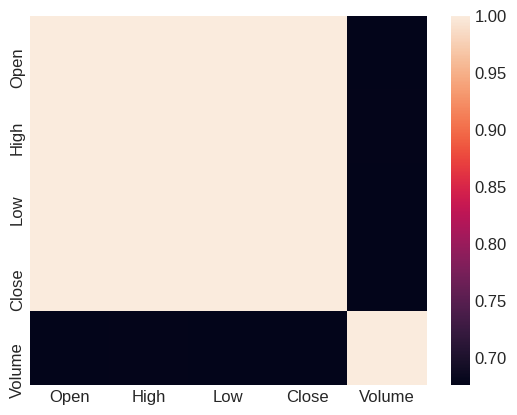

In [13]:
sns.heatmap(data.corr());

Come prevedibile, tutti i dati sono tra loro estremamente correlati ad eccezione del volume che esprime comunque un discreto livello di correlazione. Per rendere il caso di studio più interessante si decide di calcolare e aggiungere ulteriori features.

### Nuove features

Per rendere il caso di studio più interessante si decide di aggiungere alcune features che riguardano alcuni indicatori tipici della finanza e dei mercati.

Vengono aggiunte le seguenti features:


*   `SMA` è la cosiddetta media mobile semplice, che indica, per ogni giornata, la media del prezzo di chiusura degli ultimi n periodi.
*   `EMA` indica, per ogni giornata, la media mobile esponenziale. Questa consiste in una media del prezzo di chiusura e, essendo esponenziale, conferisce un peso maggiore agli ultimi periodi, determinando un valore molto più vicino alla situazione attuale del mercato piuttosto che a quella dei primi periodi considerati dalla media stessa.
*   `RSI` acronimo di Relative Strength Index, è il cosiddetto indice di forza relativo, un indicatore di analisi tecnica che segnala la forza intrinseca di un titolo. Si calcola effettuando il rapporto tra la media delle sedute borsistiche al rialzo e quelle al ribasso durante un periodo di tempo definito, di solito 14 giorni. L'oscillatore si muove tra 0 e 100, ma 30 e 70 indicano già situazioni, rispettivamente, di ipervenduto e ipercomprato che potrebbero presagire un'inversione di tendenza.
*   `MACD` è un indicatore molto popolare che può essere usato per identificare gli aspetti del trend generale di un asset. In particolare, attraverso il MACD si può valutare il momentum, insieme alla direzione del trend e la sua durata. In particolare, consideriamo questo indice suddividendo i suoi aspetti principali in due diverse features:
  *   `MACD_line` si ottiene dalla sottrazione tra la media mobile esponenziale a 12 periodi e la media mobile esponenziale a 26 periodi.
  *   `MACD_line_signal` è dato dalla media mobile esponenziale a 9 periodi della linea di MACD.
*   `Stochastic` indica il cosiddetto oscillatore stocastico, che mette in relazione i prezzi di chiusura di un indice e l’intervallo in cui i prezzi dello stesso oscillano in un determinato periodo di tempo. Indica quindi i massimi e i minimi del mercato, permettendo di poter comprendere meglio i cambiamenti subiti dal prezzo.
*   `Date` si decide inoltre di considerare anche l'indice Date, dal quale potranno essere estrapolate utili informazioni relative al giorno della settimana/mese e/o del periodo dell'anno che si sta considerando.



#### SMA: media mobile semplice

Per comprendere questa feature visualizziamo un grafico a candele dei primi 50 giorni costituenti il nostro dataset. Le giornate con chiusura positiva sono rappresentate da una candela bianca, mentre quelle a chiusura negativa da una nera. La media mobile, in questo esempio a 10 periodi (quindi la media del prezzo di chiusura degli ultimi 10 giorni), è rappresentata dalla linea azzurra. Osserviamo che, per definizione, una media mobile a n periodi potrà essere considerata solo dall'n-esimo giorno, sarà quindi necessario trattare i valori mancanti.

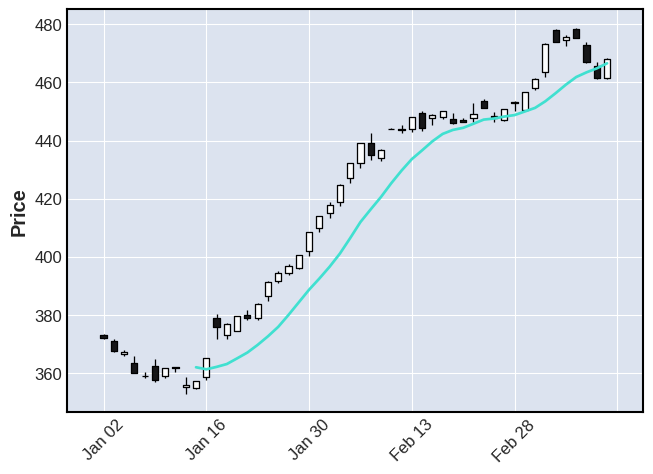

In [14]:
mpf.plot(data[:50], type='candle', mav=10)

Per questo caso di studio si sceglie di considerare le medie mobili semplici rispettivamente a 5, 10, 15, 20, 25 e 30 periodi. La loro integrazione al dataframe avviene nella cella sottostante.

In [15]:
data["SMA_5"] = data["Close"].rolling(5).mean().shift()
data["SMA_10"] = data["Close"].rolling(10).mean().shift()
data["SMA_15"] = data["Close"].rolling(15).mean().shift()
data["SMA_20"] = data["Close"].rolling(20).mean().shift()
data["SMA_25"] = data["Close"].rolling(25).mean().shift()
data["SMA_30"] = data["Close"].rolling(30).mean().shift()

##### Distribuzione delle medie mobili semplici

In [16]:
data["SMA_5"].describe()

count    5036.000000
mean     1744.743680
std       836.350339
min       358.859991
25%      1054.125989
50%      1819.095984
75%      2260.983972
max      4949.563965
Name: SMA_5, dtype: float64

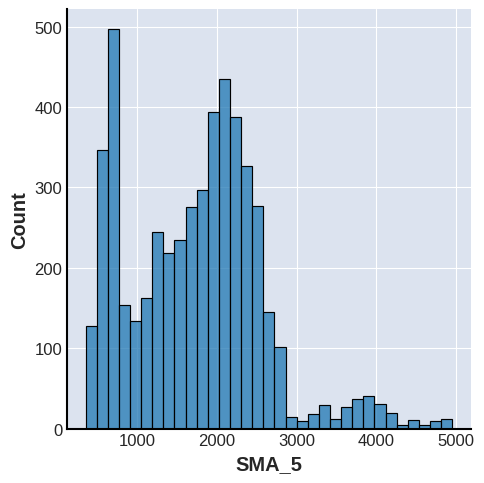

In [17]:
sns.displot(data["SMA_5"]);

In [18]:
data["SMA_10"].describe()

count    5031.000000
mean     1744.975062
std       835.327487
min       361.339999
25%      1051.508496
50%      1817.280005
75%      2262.152014
max      4881.267969
Name: SMA_10, dtype: float64

In [19]:
sns.displot(data["SMA_10"]);

In [20]:
data["SMA_15"].describe()

count    5026.000000
mean     1745.216053
std       834.342506
min       366.473334
25%      1048.787500
50%      1819.680334
75%      2264.043009
max      4840.081315
Name: SMA_15, dtype: float64

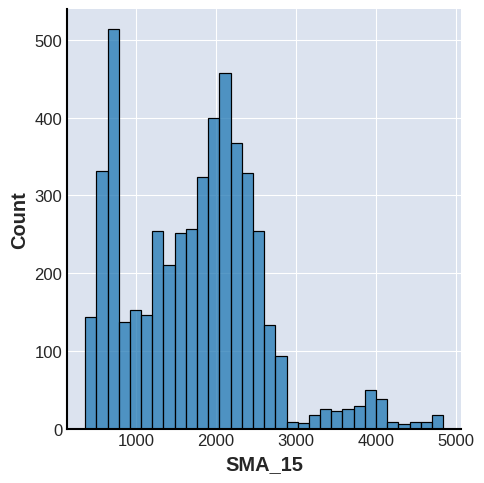

In [21]:
sns.displot(data["SMA_15"]);

In [22]:
data["SMA_20"].describe()

count    5021.000000
mean     1745.460874
std       833.346517
min       373.199998
25%      1047.236993
50%      1821.445514
75%      2262.413000
max      4839.666992
Name: SMA_20, dtype: float64

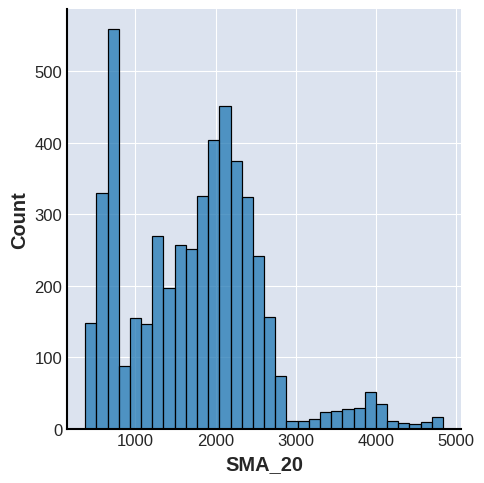

In [23]:
sns.displot(data["SMA_20"]);

In [24]:
data["SMA_25"].describe()

count    5016.000000
mean     1745.714826
std       832.344800
min       382.456000
25%      1045.599303
50%      1824.057405
75%      2265.657307
max      4796.827988
Name: SMA_25, dtype: float64

In [25]:
sns.displot(data["SMA_25"]);

In [26]:
data["SMA_30"].describe()

count    5011.000000
mean     1745.974729
std       831.348144
min       392.016667
25%      1045.189832
50%      1827.726676
75%      2263.586666
max      4743.187012
Name: SMA_30, dtype: float64

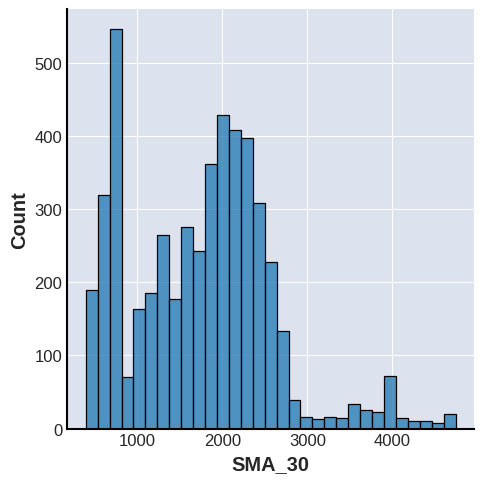

In [27]:
sns.displot(data["SMA_30"]);

Come prevedibile, le varia medie mobili semplici, sono tra loro simili in tutte le caratteristiche, in quanto si trovano sovrapposte sul dataset e su un numero così grande di osservazioni la differenza di una ripetto all'altra è irrisoria, considerando inoltre che differiscono tra loro nel calcolo della media del prezzo di chiusura di massimo 25 periodi.

La presenza, nella maggior parte delle osservazioni, di una media mobile semplice sotto il valore 3000, è dovuta al fatto che quello è stato il range medio nel quale il prezzo si è mosso nel corso dei 20 anni considerati. Osserviamo infatti che i valori maggiori sono stati registrati sicuramente a cavallo tra 1999 e 2000, quando l'indice ha raggiunto il suo picco massimo all'interno del timeframe considerato.

#### EMA: media mobile esponenziale

Sfruttiamo il comando ewm di pandas per restituire una funzione esponenziale pesata, attraverso la quale si calcolerà la media mobile esponenziale, che si è scelto di considerare a 9 periodi (giorni) per questo caso di studio.

In [28]:
data["EMA_9"] = data["Close"].ewm(9).mean().shift()

Per comprendere l'influenza del prezzo di chiusura sulla media mobile esponenziale visualizziamo un grafico del prezzo di chiusura dei primi 500 giorni del nostro dataset messo a confronto con la relativa media mobile esponenziale a 9 periodi. Anche in questo caso bisognerà tener conto delle prime osservazioni per le quali la media non può essere calcolata e presenterà valore nan.

In [29]:
plt.figure(figsize=(15,8))
sns.lineplot(y=data["Close"][:500],x=np.arange(500))
sns.lineplot(y=data["EMA_9"][:500],x=np.arange(500))
plt.legend(['Close Price','EMA-9'])
plt.title('Close Price vs EMA-9')
plt.show()

In [30]:
data["EMA_9"].describe()

count    5040.000000
mean     1740.531152
std       834.831636
min       360.865532
25%      1043.976454
50%      1819.122977
75%      2265.218284
max      4792.926856
Name: EMA_9, dtype: float64

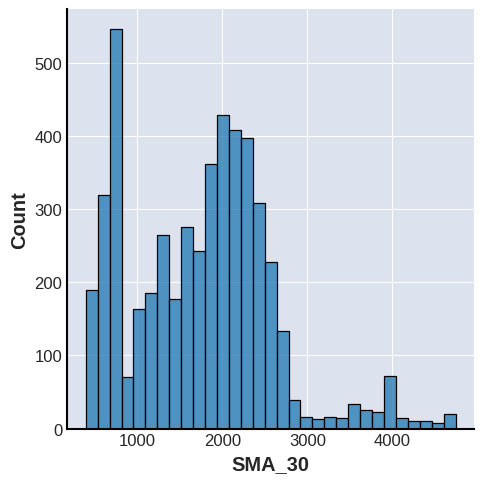

In [31]:
sns.displot(data["SMA_30"]);

Anche in questo caso valgono le osservazioni fatte per la media mobile semplice. Ovvero che la presenza, nella maggior parte delle osservazioni, di una media mobile esponenziale sotto il valore 3000, è dovuta al fatto che quello è stato il range medio nel quale il prezzo si è mosso nel corso dei 20 anni considerati. Osserviamo infatti che i valori maggiori sono stati registrati sicuramente a cavallo tra 1999 e 2000, quando l'indice ha raggiunto il suo picco massimo all'interno del timeframe considerato.

#### RSI: indice di forza relativo

Per il calcolo dell'RSI, in quanto indice più complesso, ci riconduciamo all'utilizzo dell'appostia libreria *ta*, che ci permetterà di calcolare facilmente anche l'oscillatore stocastico. Procediamo con l'installazione della libreria.

In [33]:
pip install ta

Importiamo ora la libreria ed aggiungiamo al nostro dataframe il valore dell'RSI. Anche in questo caso sarà necessario considerare i valori mancanti nelle prime osservazioni del dataset.

In [34]:
from ta.momentum import RSIIndicator

data['RSI'] = RSIIndicator(data["Close"]).rsi()

Visualizziamo ora un confronto tra RSI e prezzo.

In [35]:
f, axes = plt.subplots(2, 1, figsize=(15,16))

sns.lineplot(y=data["Close"][:1000], x=np.arange(1000), ax=axes[0])
axes[0].title.set_text("Grafico Prezzo")
axes[0].legend(["Prezzo Chiusura"])

sns.lineplot(y=30, x=np.arange(1000), ax=axes[1])
sns.lineplot(y=70, x=np.arange(1000), ax=axes[1])
sns.lineplot(y=data["RSI"][:1000], x=np.arange(1000), ax=axes[1])
axes[1].title.set_text("Grafico RSI")
axes[1].legend(["Limite Ipervenduto", "Limite Ipercomprato", "RSI"])

In [36]:
sns.displot(data["RSI"]);

Di questo indice osserviamo che, come già detto, è compreso tra 0 e 100. Un valore inferiore a 30 indica ipervenduto, mentre un valore superiore a 70 ipercomprato. Osserviamo infatti dalla sua distribuzione, che ricorda una distribuzione gaussiana, che si è mantenuto principalmente all'interno del range 30-70, superando le due soglie solo in caso di picchi rispettivamente a ribasso e a rialzo.

#### MACD

Per prima cosa osserviamo che, essendo sia *MACD line* che *MACD line signal* basati su medie mobili esponenziali, bisognerà ricordarsi di eliminare le osservazioni ad inizio dataset per le quali non è possibile calcolare né l'uno né l'altro indice.

##### MACD line

Calcoliamo MACD line come differenza tra la media mobile esponenziale a 12 periodi e quella a 26 (calcolate come in precedenza) e lo aggiungiamo ad una nuova colonna del datafreame.

In [37]:
EMA_12 = pd.Series(data["Close"].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(data["Close"].ewm(span=26, min_periods=26).mean())
data["MACD"] = pd.Series(EMA_12 - EMA_26)

In [38]:
data["MACD"].describe()

count    5016.000000
mean        3.065436
std        41.822502
min      -282.334918
25%        -8.737758
50%         5.588759
75%        21.553871
max       204.958187
Name: MACD, dtype: float64

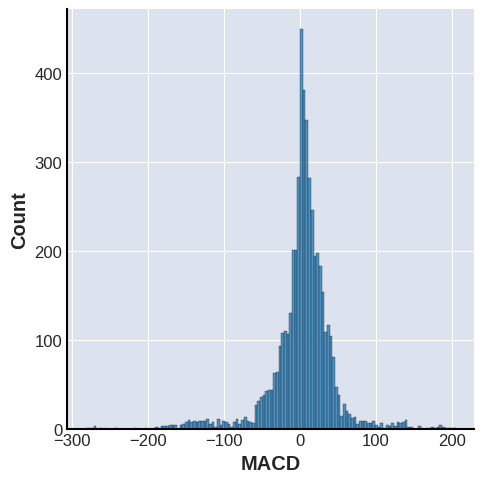

In [39]:
sns.displot(data["MACD"]);

Anche in questo caso si ha una distribuzione simile ad una gaussiana, per via del fatto che il MACD assume valori alti in valore assoluto nel caso in cui vi siano massimi e minimi, quindi picchi rispettivamente a rialzo e a ribasso. Osserviamo infatti una media vicina allo 0.

##### MACD line signal

Calcoliamo MACD line signal come media mobile esponenziale a 9 periodi della feature MACD line.

In [40]:
data["MACD_signal"] = pd.Series(data.MACD.ewm(span=9, min_periods=9).mean())

In [41]:
data["MACD_signal"].describe()

count    5008.000000
mean        3.030773
std        39.813373
min      -242.443118
25%        -8.576196
50%         5.425403
75%        20.572276
max       183.581669
Name: MACD_signal, dtype: float64

In [42]:
sns.displot(data["MACD_signal"]);

Come prevedibile, essendo una sua media mobile esponenziale, è molto simile all'indice MACD in tutte le sue caratteristiche.

#### Oscillatore stocastico

Come nel caso dell'indice RSI, per calcolare l'oscillatore stocastico, sfruttiamo la libreria *ta*. In particolare, importiamo il pacchetto necessario e procediamo con il calcolo. Anche in questo caso andranno rimosse le osservazioni iniziali, per le quali non è possibile calcolare l'indice.

In [43]:
from ta.momentum import StochasticOscillator

data["Stochastic"]=StochasticOscillator(data["High"],data["Low"],data["Close"]).stoch()

In [44]:
data["Stochastic"].describe()

count    5028.000000
mean       59.743994
std        32.189344
min         0.000000
25%        31.174344
50%        65.161525
75%        90.017889
max       100.000000
Name: Stochastic, dtype: float64

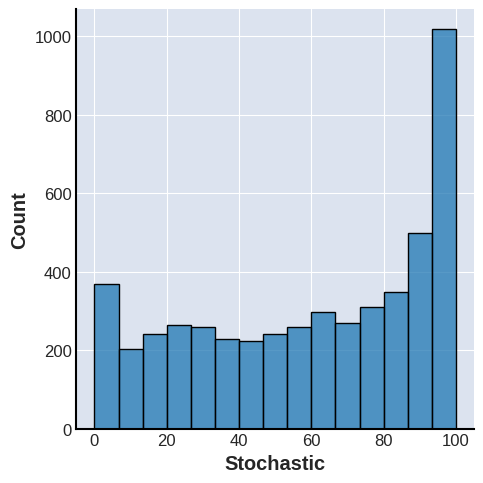

In [45]:
sns.displot(data["Stochastic"]);

#### Date

Come anticipato, trattando il nostro caso di studio della predizione di una variabile continua con forte dipendenza temporale, si decide di considerare anche tutte quelle informazioni utili che sono reperibili attraverso la data.

Per prima cosa, trasformiamo il nostro indice in una colonna del dataframe.

In [46]:
data.reset_index(inplace=True)

In [47]:
data.head()

Date        Open        High  ...  MACD  MACD_signal  Stochastic
0 1991-01-02  373.000000  373.500000  ...   NaN          NaN         NaN
1 1991-01-03  371.200012  371.799988  ...   NaN          NaN         NaN
2 1991-01-04  366.500000  367.899994  ...   NaN          NaN         NaN
3 1991-01-07  363.500000  365.799988  ...   NaN          NaN         NaN
4 1991-01-08  359.100006  360.500000  ...   NaN          NaN         NaN

[5 rows x 17 columns]

A questo punto si decide di importare la funzione *add_datepart* della libreria *fastai*, che permette di estrapolare una serie di informazioni utili dalla data, quali anno, mese, settimana, giorno, giorno della settimana, giorno dell'anno, se si tratta di inizio o fine mese, se si tratta di inizio o fine quadrimestre e se si tratta di inizio o fine anno. 

Importiamo e applichiamo dunque tale funzione al nostro dataset.

In [48]:
from fastai.tabular import add_datepart

add_datepart(data, "Date", drop=False)

/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


Date         Open  ...  Is_year_start     Elapsed
0    1991-01-02   373.000000  ...          False   662774400
1    1991-01-03   371.200012  ...          False   662860800
2    1991-01-04   366.500000  ...          False   662947200
3    1991-01-07   363.500000  ...          False   663206400
4    1991-01-08   359.100006  ...          False   663292800
...         ...          ...  ...            ...         ...
5036 2010-12-23  2667.419922  ...          False  1293062400
5037 2010-12-27  2657.090088  ...          False  1293408000
5038 2010-12-28  2671.850098  ...          False  1293494400
5039 2010-12-29  2667.179932  ...          False  1293580800
5040 2010-12-30  2665.679932  ...          False  1293667200

[5041 rows x 30 columns]

Osserviamo che i valori di *Is_month_end*, *Is_month_start*, *Is_quarter_end*, *Is_quarter_start*, *Is_year_end* e *Is_year_start* sono in formato booleano del tipo {false, true}. Si decide quindi di sfruttare il LabelEncoder di scikit learn per trasformarli rispettivamente in 0 e 1, eliminando quindi la presenza di variabili categoriche.

In [50]:
from sklearn.preprocessing import LabelEncoder

def labelencode(share):
    LE=LabelEncoder()
    data["Is_month_end"]=LE.fit_transform(data["Is_month_end"])
    data["Is_month_start"]=LE.fit_transform(data["Is_month_start"])
    data["Is_quarter_end"]=LE.fit_transform(data["Is_quarter_end"])
    data["Is_quarter_start"]=LE.fit_transform(data["Is_quarter_start"])
    data["Is_year_end"]=LE.fit_transform(data["Is_year_end"])
    data["Is_year_start"]=LE.fit_transform(data["Is_year_start"])

In [51]:
labelencode(data)

In [52]:
data.head()

Date        Open        High  ...  Is_year_end  Is_year_start    Elapsed
0 1991-01-02  373.000000  373.500000  ...            0              0  662774400
1 1991-01-03  371.200012  371.799988  ...            0              0  662860800
2 1991-01-04  366.500000  367.899994  ...            0              0  662947200
3 1991-01-07  363.500000  365.799988  ...            0              0  663206400
4 1991-01-08  359.100006  360.500000  ...            0              0  663292800

[5 rows x 30 columns]

### Aggiustamento features

Una considerazione molto importante da fare riguarda ciò che si conosce al momento della predizione. Supponendo di effettuare una predizione all'apertura della borsa è noto soltanto il prezzo di apertura dell'indice. Questo causa alcuni problemi, in quanto le numerose features aggiunte si basano principalmente sul prezzo di chiusura o comunque su altri valori non determinabili ad inizio giornata.

Per risolvere questo problema si decide di effettuare uno shift del prezzo di chiusura indietro di una posizione, in modo tale da considerare per la predizione del prezzo di una giornata tutte le features relative al giorno precedente.

In [53]:
data["Close"] = data["Close"].shift(-1)

Per questioni di leggibilità in quanto variabile da predirre, decidiamo inoltre di spostare la colonna *Close* rendendola l'ultima colonna della tabella.

In [54]:
data["Close"] = data.pop("Close")

In [55]:
data.tail()

Date         Open  ...     Elapsed        Close
5036 2010-12-23  2667.419922  ...  1293062400  2667.270020
5037 2010-12-27  2657.090088  ...  1293408000  2662.879883
5038 2010-12-28  2671.850098  ...  1293494400  2666.929932
5039 2010-12-29  2667.179932  ...  1293580800  2662.979980
5040 2010-12-30  2665.679932  ...  1293667200          NaN

[5 rows x 30 columns]

### Trattamento dei valori mancanti

Verifichiamo la presenza di valori mancanti che, in base alle considerazioni precedenti, dovrebbe dare esito positivo.

In [56]:
data.isnull().values.any()

True

Possiamo osservare infatti la presenza di valori mancanti rispettivamente nelle prime 33 osservazioni (dovute alle medie mobili necessarie per il funzionamento del MACD che causano l'assenza di valori maggiore) e nell'ultima osservazione, nella quale non è più disponibile il valore di chiusura in quanto abbiamo eseguito lo shift di una posizione per poter attuare le predizioni.

In [57]:
data.head()

Date        Open        High  ...  Is_year_start    Elapsed       Close
0 1991-01-02  373.000000  373.500000  ...              0  662774400  367.500000
1 1991-01-03  371.200012  371.799988  ...              0  662860800  367.200012
2 1991-01-04  366.500000  367.899994  ...              0  662947200  360.200012
3 1991-01-07  363.500000  365.799988  ...              0  663206400  359.000000
4 1991-01-08  359.100006  360.500000  ...              0  663292800  357.500000

[5 rows x 30 columns]

In [58]:
data.tail()

Date         Open  ...     Elapsed        Close
5036 2010-12-23  2667.419922  ...  1293062400  2667.270020
5037 2010-12-27  2657.090088  ...  1293408000  2662.879883
5038 2010-12-28  2671.850098  ...  1293494400  2666.929932
5039 2010-12-29  2667.179932  ...  1293580800  2662.979980
5040 2010-12-30  2665.679932  ...  1293667200          NaN

[5 rows x 30 columns]

Effettuiamo quindi il drop di tutte le righe che contengono valori nan.

In [59]:
data.dropna(inplace=True)

Si esegue ora un rapido check dello spazio occupato in memoria con l'aggiunta delle nuove features.

In [60]:
data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5007 entries, 33 to 5039
Columns: 30 entries, Date to Close
dtypes: datetime64[ns](1), float64(15), int64(14)
memory usage: 1.2 MB


Come prevedibile, lo spazio occupato è aumentato in relazione all'aumento del numero di features ma si mantiene comunque molto basso.

### Analisi relazioni con nuove features

In [61]:
data.describe()

Open         High  ...       Elapsed        Close
count  5007.000000  5007.000000  ...  5.007000e+03  5007.000000
mean   1754.359505  1768.796862  ...  9.798855e+08  1753.886326
std     834.804286   844.262715  ...  1.811233e+08   832.733995
min     447.000000   447.700012  ...  6.669216e+08   446.000000
25%    1065.169983  1069.715027  ...  8.230032e+08  1065.625000
50%    1825.910034  1843.199951  ...  9.796032e+08  1828.680054
75%    2265.324951  2280.934937  ...  1.136808e+09  2264.109985
max    5060.339844  5132.520020  ...  1.293581e+09  5048.620117

[8 rows x 29 columns]

In [62]:
data.corr()

Open      High  ...   Elapsed     Close
Open              1.000000  0.999740  ...  0.627672  0.998257
High              0.999740  1.000000  ...  0.626226  0.998652
Low               0.999573  0.999469  ...  0.632162  0.998638
Volume            0.671669  0.673411  ...  0.895165  0.672343
SMA_5             0.998650  0.998708  ...  0.629982  0.997089
SMA_10            0.997211  0.997498  ...  0.630671  0.995758
SMA_15            0.995767  0.996224  ...  0.631354  0.994252
SMA_20            0.994133  0.994732  ...  0.632074  0.992574
SMA_25            0.992460  0.993182  ...  0.632840  0.990897
SMA_30            0.990738  0.991557  ...  0.633639  0.989133
EMA_9             0.995743  0.996246  ...  0.632979  0.994197
RSI              -0.035631 -0.037084  ... -0.115978 -0.027079
MACD              0.112374  0.106029  ... -0.028679  0.114802
MACD_signal       0.122935  0.116777  ... -0.031694  0.124032
Stochastic       -0.012407 -0.011401  ... -0.060610 -0.000130
Year              0.627689  0.626254  ...  0.998761  0.629128
Month             0.005799  0.005583  ...  0.034881  0.007019
Week              0.005307  0.005087  ...  0.034849  0.006300
Day               0.001094  0.000775  ...  0.001612  0.001053
Dayofweek         0.003088  0.003170  ...  0.001526  0.003484
Dayofyear         0.006410  0.006177  ...  0.034814  0.007611
Is_month_end      0.003847  0.003931  ... -0.000606  0.005319
Is_month_start    0.001315  0.001861  ... -0.000600  0.003296
Is_quarter_end   -0.002108 -0.002316  ...  0.000388 -0.002011
Is_quarter_start -0.019080 -0.019027  ... -0.002281 -0.018651
Is_year_end       0.002574  0.002315  ... -0.000496  0.003403
Is_year_start          NaN       NaN  ...       NaN       NaN
Elapsed           0.627672  0.626226  ...  1.000000  0.629171
Close             0.998257  0.998652  ...  0.629171  1.000000

[29 rows x 29 columns]

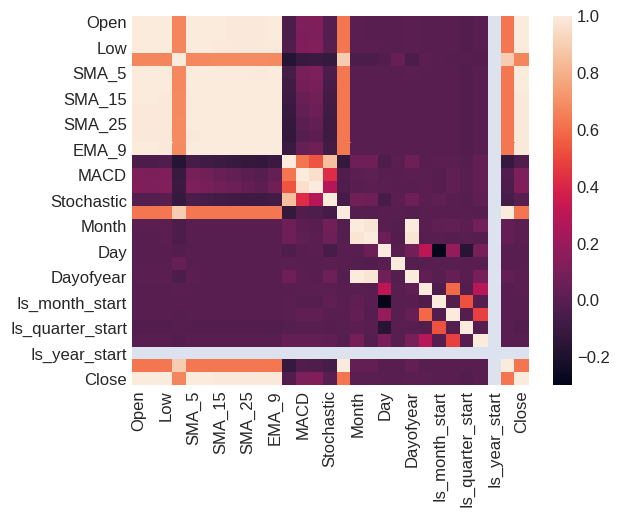

In [63]:
sns.heatmap(data.corr())

Si osserva che ora la matrice di correlazione è decisamente più interessante, sebbene le correlazioni siano nella maggior parte dei casi meno forti di quelle tra le features di partenza. In particolare, osserviamo che le features estratte da *Date* hanno correlazione quasi nulla con il prezzo di chiusura. Testeremo quindi alcuni modelli sia con che senza il loro utilizzo per verificare se effettivamente non sono determinanti nella predizione del prezzo di chiusura. Si osserva infine che la feature *Is_year_start* non assume mai valore positivo in quanto effettivamente il primo giorno dell'anno è sempre festivo e quindi non vi sono osservazioni che lo comprendono. Dovremo preocedere con la sua rimozione.

### Selezione features

Si procede ora con la rimozione di quelle features considerate superflue ai fini della creazione di un modello di regressione in grado di approssimare nel miglior modo possibile il comportamento dell'indice oggetto del caso di studio.

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5007 entries, 33 to 5039
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              5007 non-null   datetime64[ns]
 1   Open              5007 non-null   float64       
 2   High              5007 non-null   float64       
 3   Low               5007 non-null   float64       
 4   Volume            5007 non-null   int64         
 5   SMA_5             5007 non-null   float64       
 6   SMA_10            5007 non-null   float64       
 7   SMA_15            5007 non-null   float64       
 8   SMA_20            5007 non-null   float64       
 9   SMA_25            5007 non-null   float64       
 10  SMA_30            5007 non-null   float64       
 11  EMA_9             5007 non-null   float64       
 12  RSI               5007 non-null   float64       
 13  MACD              5007 non-null   float64       
 14  MACD_signal       5007 

Osserviamo che sono ora presenti 29 features e la variabile continua da predirre.

Per prima cosa ripristiniamo la colonna *Date* come indice, per garantire una maggiore leggibilità.

In [65]:
data.set_index("Date", inplace=True)

Salviamo poi in una serie a parte il valore di apertura, che ci servirà poi per il calcolo dei profitti.

In [66]:
open = data["Open"]

A questo punto possiamo procedere con la rimozione delle features ritenute superflue.

In particolare, si decide di rimuovere *Open*, *High*, *Low* e *Volume* in quanto il loro contenuto informativo è presente anche nelle nuove features che abbiamo creato. Eliminiamo anche *Year* ed *Elapsed* in quanto poco significative per la generazione di un modello di regressione. Infine si decide di rimuovere *Is_year_start* in quanto essendo sempre il primo dell'anno un giorno festivo questa non avrà mai valore diverso da 0.

In [67]:
drop_cols = ["Open", "High", "Low", "Volume", "Year", "Elapsed", "Is_year_start"]

data.drop(drop_cols, 1, inplace=True)

Abbiamo dunque ridotto il numero di features a 21. Altre dipendenze potranno essere scovate anche mediante l'utilizzo di formule di regolarizzazione, sfruttando in particolare la regressione lasso.

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5007 entries, 1991-02-19 to 2010-12-29
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SMA_5             5007 non-null   float64
 1   SMA_10            5007 non-null   float64
 2   SMA_15            5007 non-null   float64
 3   SMA_20            5007 non-null   float64
 4   SMA_25            5007 non-null   float64
 5   SMA_30            5007 non-null   float64
 6   EMA_9             5007 non-null   float64
 7   RSI               5007 non-null   float64
 8   MACD              5007 non-null   float64
 9   MACD_signal       5007 non-null   float64
 10  Stochastic        5007 non-null   float64
 11  Month             5007 non-null   int64  
 12  Week              5007 non-null   int64  
 13  Day               5007 non-null   int64  
 14  Dayofweek         5007 non-null   int64  
 15  Dayofyear         5007 non-null   int64  
 16  Is_month_end      5007 n

## Creazione e valutazione dei modelli di regressione

Lo scopo di questa fase è quello di creare e valutare diversi modelli di regressione, allo scopo di trovare quello più performante per il caso di studio considerato.

Procediamo con l'inport delle classi utili fornite dalla libreria scikit learn per questa fase.

In [69]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [70]:
import warnings
warnings.filterwarnings('ignore')

### Splitter per metodo Hold-Out

Per i primi test utilizzeremo il metodo hold-out, suddividendo quindi i nostri dati in training set e validation set. Iniziamo creando una funzione che permetta di effettuare la suddivisione sulla base di un determinato anno. Tutte le osservazioni antecedenti a quel determinato anno verranno inserite nel dataset di training, mentre quelle da quel determinato anno in poi saranno inserite nel dataset di validation.

In [71]:
def split_before_year(X, y, year):
    is_train = X.index.year < year
    X_train = X.loc[is_train]
    y_train = y.loc[is_train]
    X_val = X.loc[~is_train]
    y_val = y.loc[~is_train]
    return X_train, X_val, y_train, y_val

Procediamo ora con la suddivisione del dataset, prima nella matrice X e nel vettore y e poi in training e validation set. Si decide di considerare come training set i dati dal 1991 al 2004, mentre come validation set quelli dal 2005 al 2010. In questo modo avremo il 70% dei dati nel training set e il 30% nel validation set.

In [72]:
X = data.loc[:, data.columns != "Close"]
y = data["Close"]

X_train, X_val, y_train, y_val = split_before_year(X, y, 2005)

### Definizione metriche di valutazione

Si decide di iniziare definendo le metriche standard attraverso le quali valutare la bontà dei modelli. In particolare, definiamo ora le funzioni che ci permettono di calcolare lo scarto quadratico medio, l'errore relativo e il coefficiente di determinazione R².



In [73]:
def relative_error(y_predicted, y_true):
    return np.mean(np.abs((y_true - y_predicted) / y_true))

def get_errors(X, y_predicted, y_true, model):
    mse = mean_squared_error(y_true, y_predicted)
    re = relative_error(y_true, y_predicted)
    r2 = model.score(X, y_true)
    return mse, re, r2

Oltre ai normali errori, dato che lo scopo della previsione di un indice di borsa è quello di generare profitto, dobbiamo considerare anche ulteriori metriche, che verifichino se un determinato modello è in grado di effettuare una previsione efficiente.

*   `gain` è il profitto vero e proprio. In questo caso per semplicità supponiamo di aprire una posizione long o short (a seconda della previsione restituita dal modello) per un valore pari a quello di apertura del titolo. Si introduce opzionalmente un parametro *delta*, determinato dal valore assoluto di *valore_chiusura_predetto - valore_apertura*. Nel caso in cui questo delta sia quindi troppo basso l'operazione è da considerarsi rischiosa e fissando questa soglia si può decidere di non effettuarla al di sotto di essa.
*   `ROI` indica il return on investment, ovvero il profitto generato in percentuale sull'investimento nel lasso di tempo del validation set. Si calcola come rapporto tra il *gain* e la media del valore di apertura.

In [74]:
def gain(C, C_pred, delta):
    open_value = open.reindex_like(C)
    CO_diff = C - open_value
    growth = (C_pred > open_value) & (abs(C_pred - open_value) > delta)
    decline = (C_pred < open_value) & (abs(C_pred - open_value) > delta)
    return CO_diff[growth].sum() - CO_diff[decline].sum()

In [75]:
def roi(C, C_pred, delta=0):
    mean_open = open.reindex_like(C).mean()
    return gain(C, C_pred, delta) / mean_open

Definiamo poi una funzione per stampare tutte le metriche sopra definite.

In [76]:
def print_eval(X, y, model, delta=0):
    preds = model.predict(X)
    mse, re, r2 = get_errors(X, preds, y, model)
    print("Scarto Quadratico Medio: {:.5}".format(mse))
    print("Errore Relativo:         {:.5%}".format(re))
    print("Coeff. Det. R²:          {:.5}".format(r2))
    print("Profitto:                {:.2f}$".format(gain(y, preds, delta)))
    print("ROI:                     {:.3%}".format(roi(y, preds, delta)))

Risulta necessario anche definire una metrica con la quale valuteremo la cross validation. Sfruttiamo quindi scikit learn per creare un oggetto scorer, incapsulando la metrica roi precedentemente calcolata. Specifichiamo greater_is_better=True per indicare di considerare migliori i modelli con score più alto, al contrario di come avviene di default con gli errori tradizionali.

In [77]:
roi_scorer = make_scorer(roi, greater_is_better=True)

Infine creiamo un'altra funzione che ci permetta di visualizzare in un grafico le differenze tra prezzo predetto e prezzo reale.

In [78]:
def print_figure(X, y, model, range=len(X_val)):
    y_predicted = model.predict(X)
    y_true = y
    plt.figure(figsize=(15, 8))
    sns.lineplot(y=y_predicted, x=np.arange(range))
    sns.lineplot(y=y_true, x=np.arange(range))
    plt.legend(["Prezzo Predetto", "Prezzo Reale"])
    plt.title("Prezzo Predetto vs Prezzo Reale")
    plt.show()

### K-fold per serie temporali

Nella k-fold i dati vengono suddivisi in k fold mescolati casualmente, tuttavia la nostra situazione è quella di una serie temporale. Sarebbe quindi opportuno mantenere una conseguenza temporale tra gli elementi dei vari fold.

Scikit learn mette a disposizione il TimeSeriesSplit(k) per questa situazione. Definiamo quindi una seria temporale con 3 split.

In [79]:
tss = TimeSeriesSplit(3)

Stampiamo ora i vari fold per renderci conto di come sono stati effettuati gli slplit temporali.

In [80]:
for i, (train, val) in enumerate(tss.split(X_train), start=1):
    print("FOLD {}".format(i))
    train_dates = X.index[train]
    val_dates = X.index[val]
    print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
    print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))

FOLD 1
Training set da 1991-02-19 00:00:00 a 1994-08-04 00:00:00
Validation set da 1994-08-05 00:00:00 a 1998-01-20 00:00:00
FOLD 2
Training set da 1991-02-19 00:00:00 a 1998-01-20 00:00:00
Validation set da 1998-01-21 00:00:00 a 2001-07-09 00:00:00
FOLD 3
Training set da 1991-02-19 00:00:00 a 2001-07-09 00:00:00
Validation set da 2001-07-10 00:00:00 a 2004-12-31 00:00:00


### Generazione modelli

#### Regressione Lasso

Per prima cosa tentiamo la regolarizzazione tramite regressione Lasso per verificare se è possibile eliminare alcune features poco rilevanti o dipendenti tra loro.

Creiamo una pipeline ed effettuiamo una grid search sulla nostra serie temporale suddivisa in 3 split per tentare di individuare gli iperparametri migliori. Proviamo inoltre sia con i dati standardizzati che non.

In [81]:
lasso = Pipeline([
    ("scale",  None),
    ("lasso", Lasso())
])

grid = {
    "scale": [None, StandardScaler()],
    "lasso__alpha": [0.001, 0.01, 0.1, 0.5, 1]
}

In [82]:
gs = GridSearchCV(lasso, grid, cv=tss, scoring=roi_scorer)
gs.fit(X_train, y_train);
sel = ["rank_test_score","mean_test_score","params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

rank_test_score  ...                                             params
3                1  ...  {'lasso__alpha': 0.01, 'scale': StandardScaler...
6                2  ...               {'lasso__alpha': 0.5, 'scale': None}
8                3  ...                 {'lasso__alpha': 1, 'scale': None}
5                4  ...  {'lasso__alpha': 0.1, 'scale': StandardScaler(...
1                5  ...  {'lasso__alpha': 0.001, 'scale': StandardScale...
0                6  ...             {'lasso__alpha': 0.001, 'scale': None}
2                7  ...              {'lasso__alpha': 0.01, 'scale': None}
4                8  ...               {'lasso__alpha': 0.1, 'scale': None}
7                9  ...  {'lasso__alpha': 0.5, 'scale': StandardScaler(...
9               10  ...  {'lasso__alpha': 1, 'scale': StandardScaler(co...

[10 rows x 3 columns]

Osserviamo che si ottiene il risultato migliore con l'alpha della lasso a 0.01 e i dati standardizzati. Riaddestriamo ora sull'intero training set con questi parametri ed eseguiamo una valutazione dei risultati ottenuti.

In [83]:
lasso = Pipeline([
    ("scale",  StandardScaler()),
    ("lasso", Lasso(alpha=0.01))
])

lasso.fit(X_train, y_train);

Stampiamo ora le metriche di valutazione e il grafico che mostra le differenze tra il prezzo di chiusura predetto e quello reale.

In [84]:
print_eval(X_val, y_val, lasso)

Scarto Quadratico Medio: 1389.8
Errore Relativo:         1.31823%
Coeff. Det. R²:          0.98486
Profitto:                13733.95$
ROI:                     619.895%


Come prevedibile abbiamo ottenuto un coefficiente di determinazione R² molto elevato ed un errore relativo dell'1.3%. Anche il ROI risulta soddisfacente con quasi il 620% di profitto sui 6 anni del validation set. Unica nota dolente lo scarto quadratico medio che comunque attendevamo elevato per via della difficoltà del task.

Stampiamo ora le caratteristiche della differenza in valore assoluto tra il prezzo di chiusura e quello di apertura sul training set per verificare se può essere conveniente evitare di effettuare operazioni di trading nel caso in cui il valore sia troppo basso.

In [82]:
abs(y_train - open.reindex_like(y_train)).describe()

count    3498.000000
mean       28.926586
std        44.735178
min         0.010010
25%         5.109985
50%        13.065063
75%        33.737488
max       560.630127
dtype: float64

Osserviamo che nel 25% dei casi queso valore è inferiore a 5 e visti gli errori del nostro modello può essere conveniente non operare in questi casi.

In [83]:
print_eval(X_val, y_val, lasso, delta=5)

Scarto Quadratico Medio: 1389.8
Errore Relativo:         1.31823%
Coeff. Det. R²:          0.98486
Profitto:                14113.88$
ROI:                     637.043%


Si nota un incremento, anche se relativamente basso, del ROI.


---

Visualizziamo ora alcuni grafici per comprendere la differenza di prezzo tra la predizione e i valori reali.

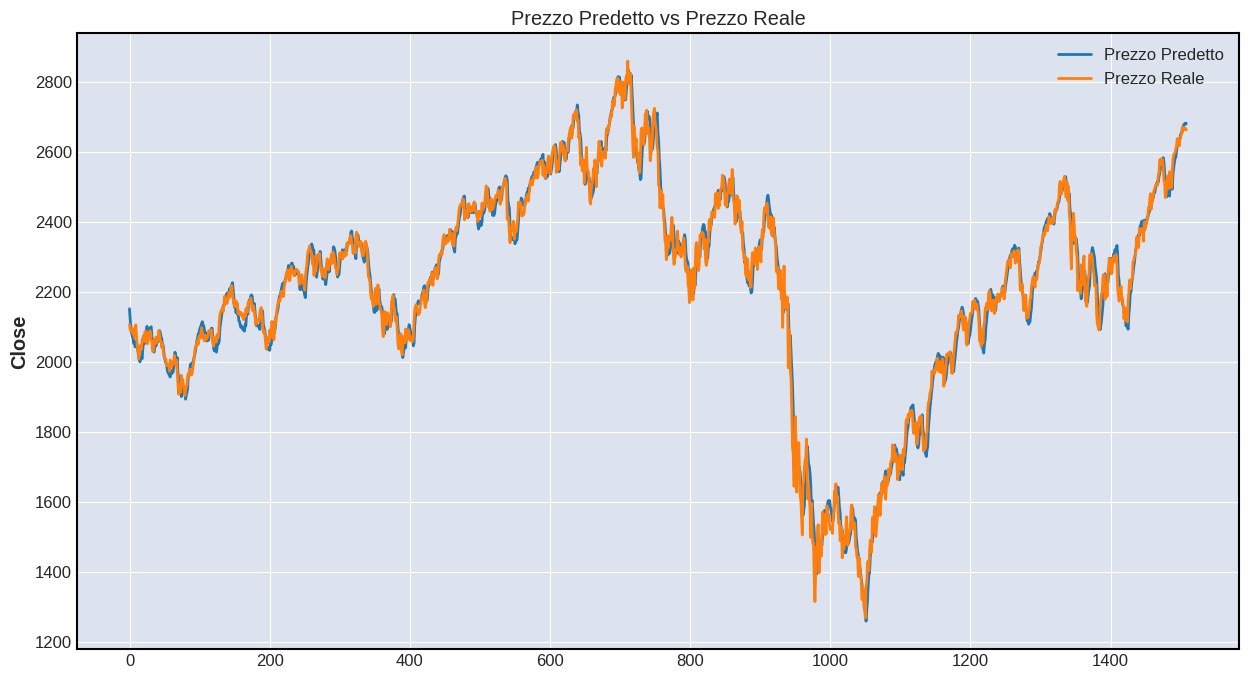

In [84]:
print_figure(X_val, y_val, lasso)

Dal grafico osserviamo che la linea blu segue quella reale complessivamente abbastanza bene, mentre ovviamente considerando un intervallo più ristretto (200 giorni) si individuano maggiori discrepanze.

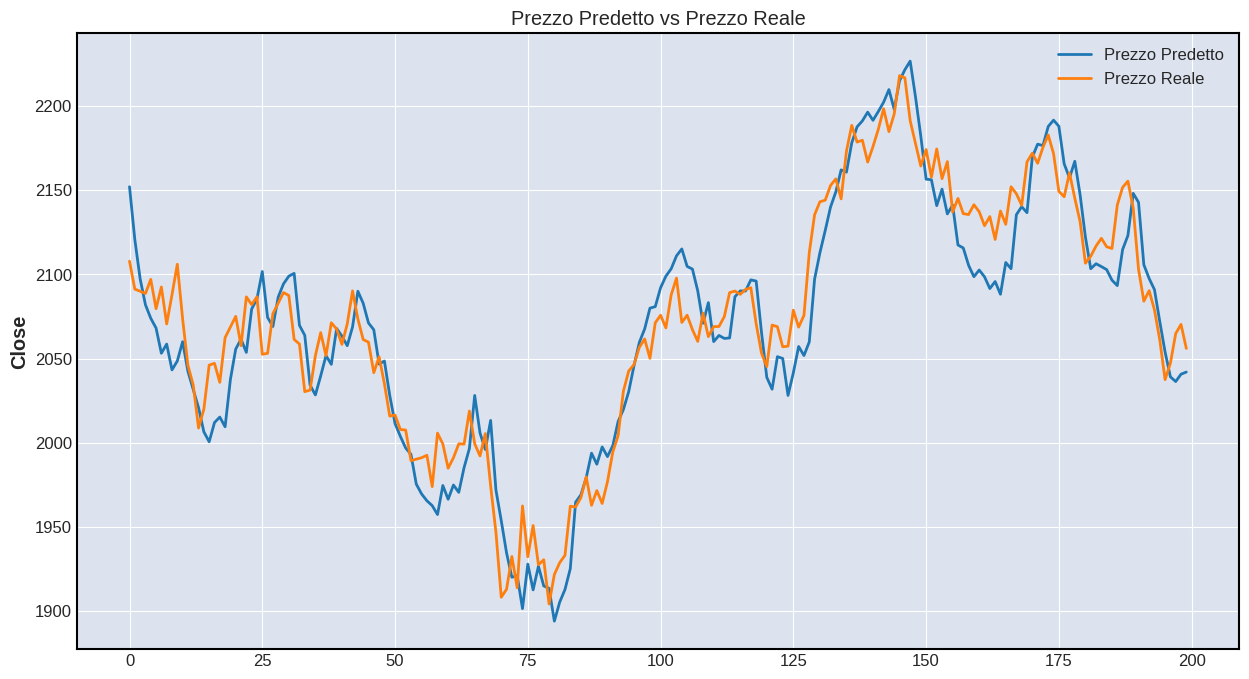

In [85]:
print_figure(X_val[:200], y_val[:200], lasso, 200)

Definiamo ora una funzione per visualizzare i pesi dati alle features dalla Lasso e osservare quali sono state eliminate.

In [93]:
def get_coeff(model):
    return pd.Series(model.coef_, index = data.loc[:, data.columns != "Close"].columns)

print(get_coeff(lasso.named_steps["lasso"]))

SMA_5               356.841476
SMA_10              364.757885
SMA_15              298.124408
SMA_20              121.010017
SMA_25               78.162592
SMA_30              -52.878838
EMA_9              -260.008363
RSI                  -5.214832
MACD                161.245925
MACD_signal        -138.647781
Stochastic           22.135909
Month                 5.047803
Week                 -5.577680
Day                   0.114260
Dayofweek             0.095119
Dayofyear             0.000000
Is_month_end          0.786247
Is_month_start        1.156643
Is_quarter_end       -1.339313
Is_quarter_start      0.041778
Is_year_end           0.768225
dtype: float64


Si osserva che i coefficienti con peso maggiore sono quelli relativi alle medie mobili semplice ed esponenziale. I dati ricavati dalla feature *Date* sono meno rilevanti per il modello e *Dayofyear* viene addirittura scartato. Dato che è stata scartata una sola feature risulta difficile selezionarne un gruppo ritretto che mantenga una ROI elevata.             

#### Regressione Ridge

Generiamo ora un modello di regressione ridge per valutare i risultati ottenuti da un modello di regressione lineare a cui applichiamo questo tipo di regolarizzazione. 

Anche in questo caso creiamo una pipeline ed effettuiamo una grid search sulla nostra serie temporale suddivisa in 3 split per tentare di individuare gli iperparametri migliori. Proviamo inoltre sia con i dati standardizzati che non.

In [87]:
ridge = Pipeline([
    ("scale",  None),
    ("ridge", Ridge())
])

grid = {
    "scale": [None, StandardScaler()],
    "ridge__alpha": [0.001, 0.01, 0.1, 0.5, 1, 10, 50]
}

In [88]:
gs = GridSearchCV(ridge, grid, cv=tss, scoring=roi_scorer)
gs.fit(X_train, y_train);
sel = ["rank_test_score","mean_test_score","params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

rank_test_score  ...                                             params
1                 1  ...  {'ridge__alpha': 0.001, 'scale': StandardScale...
3                 2  ...  {'ridge__alpha': 0.01, 'scale': StandardScaler...
8                 3  ...                 {'ridge__alpha': 1, 'scale': None}
6                 4  ...               {'ridge__alpha': 0.5, 'scale': None}
0                 5  ...             {'ridge__alpha': 0.001, 'scale': None}
2                 5  ...              {'ridge__alpha': 0.01, 'scale': None}
4                 7  ...               {'ridge__alpha': 0.1, 'scale': None}
10                8  ...                {'ridge__alpha': 10, 'scale': None}
12                9  ...                {'ridge__alpha': 50, 'scale': None}
5                10  ...  {'ridge__alpha': 0.1, 'scale': StandardScaler(...
7                11  ...  {'ridge__alpha': 0.5, 'scale': StandardScaler(...
9                12  ...  {'ridge__alpha': 1, 'scale': StandardScaler(co...
11               13  ...  {'ridge__alpha': 10, 'scale': StandardScaler(c...
13               14  ...  {'ridge__alpha': 50, 'scale': StandardScaler(c...

[14 rows x 3 columns]

Osserviamo che il risultato migliore di ottiene con una regolarizzazione molto bassa, con parametro alpha=0.001 e con la standardizzazione dei dati.

Addestriamo ora il modello con gli iperparametri migliori sul training set completo e procediamo con la sua valutazione.

In [85]:
ridge = Pipeline([
    ("scale",  StandardScaler()),
    ("ridge", Ridge(alpha=0.001))
])

ridge.fit(X_train, y_train);

In [86]:
print_eval(X_val, y_val, ridge)

Scarto Quadratico Medio: 970.74
Errore Relativo:         1.06988%
Coeff. Det. R²:          0.98942
Profitto:                23692.83$
ROI:                     1069.398%


Osserviamo che tutte le metriche di valutazione sono migliorate rispetto alla lasso. Lo scarto quadratico medio si è ridotto e anche l'errore relativo è diminuito sino all'1%. Il coefficiente di determinazione R² si avvicina maggiormente a 0.99 e il ROI è aumentato fino a quasi il 1070%.

Proviamo ora ad utilizzare il delta nel calcolo del ROI.

In [91]:
print_eval(X_val, y_val, ridge, delta=5)

Scarto Quadratico Medio: 970.74
Errore Relativo:         1.06988%
Coeff. Det. R²:          0.98942
Profitto:                23036.05$
ROI:                     1039.754%


Osserviamo che in questo caso si verifica una lieve diminuzione del ROI, non ottenendo quindi alcun beneficio.

---

Procediamo ora con la visualizzazione grafica.

In [92]:
print_figure(X_val, y_val, ridge)

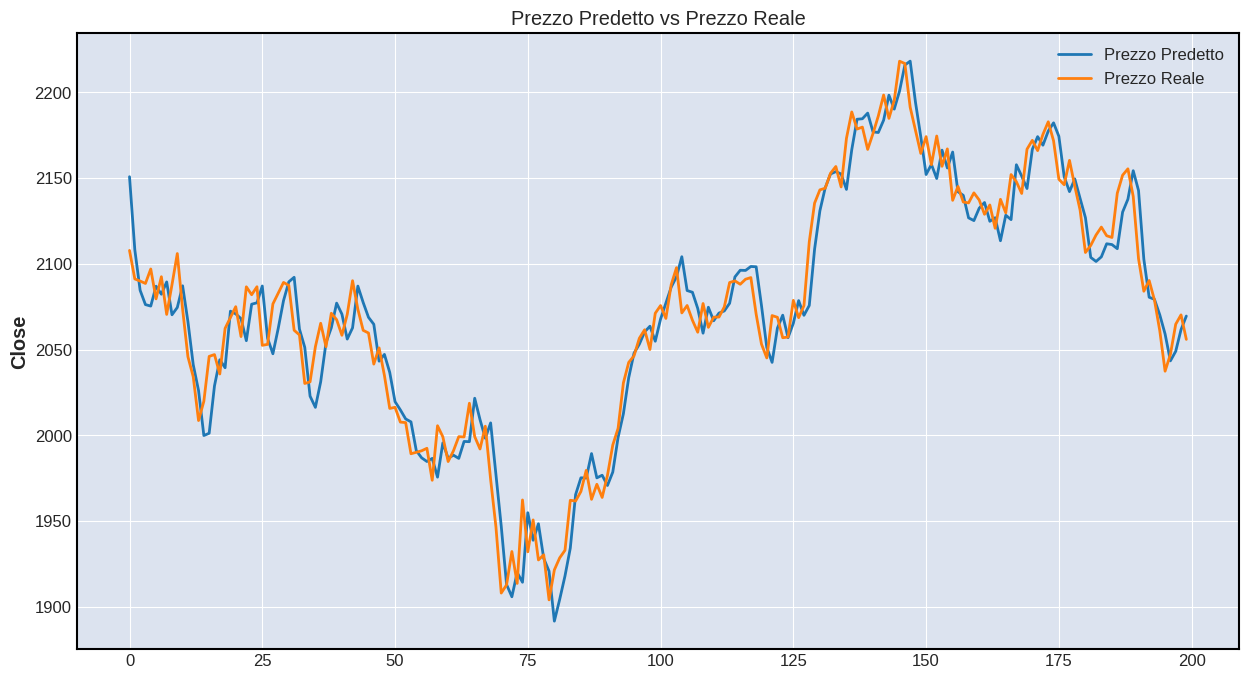

In [93]:
print_figure(X_val[:200], y_val[:200], ridge, 200)

Si osserva quindi, in particolare dal confronto dei grafici a 200 periodi, che effettivamente con un ROI del 1070% su 6 anni il modello con regressione Ridge approssima molto meglio il prezzo di chiusura rispetto a quello con regressione lasso.



---

Procediamo infine con la visualizzazione dei pesi assegnati alle varie features.

In [94]:
print(get_coeff(ridge.named_steps["ridge"]))

SMA_5               -629.739026
SMA_10              1348.662413
SMA_15              1205.051412
SMA_20               767.822573
SMA_25               914.230079
SMA_30               689.613782
EMA_9              -3386.395044
RSI                   -1.948505
MACD                 473.101467
MACD_signal         -373.806540
Stochastic             6.702616
Month                 99.657204
Week                  -2.228246
Day                    8.513416
Dayofweek             -0.152550
Dayofyear            -98.104727
Is_month_end           1.635845
Is_month_start         0.580671
Is_quarter_end        -1.884387
Is_quarter_start       0.056048
Is_year_end            0.884094
dtype: float64


#### Regressione Lineare

Creiamo e addestriamo ora un semplice modello di regressione lineare senza regolarizzazione, per confrontarlo con i precedenti modelli.

Sfruttiamo la *grid search* per verificare se si ottengono risultati migliori con o senza standardizzazione dei dati.

In [95]:
linreg = Pipeline([
    ("scale",  None),
    ("linreg", LinearRegression())
])

grid = {
    "scale": [None, StandardScaler()],
}

In [96]:
gs = GridSearchCV(linreg, grid, cv=tss, scoring=roi_scorer)
gs.fit(X_train, y_train);
sel = ["rank_test_score","mean_test_score","params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

rank_test_score  ...                                             params
0                1  ...                                    {'scale': None}
1                1  ...  {'scale': StandardScaler(copy=True, with_mean=...

[2 rows x 3 columns]

Osserviamo che la presenza dello *StandardScaler* non influenza lo score ottenuto. 

Procediamo quindi con l'addestramento su tutto il training set.

In [87]:
linreg = LinearRegression()
linreg.fit(X_train, y_train);

In [88]:
print_eval(X_val, y_val, linreg)

Scarto Quadratico Medio: 970.79
Errore Relativo:         1.06939%
Coeff. Det. R²:          0.98942
Profitto:                23752.15$
ROI:                     1072.075%


I risultati ottenuti sono pressochè identici a quelli ricavati dalla regressione ridge, dove abbiamo effettivamente considerato un valore di alpha molto piccolo. Il prezzo sembra dunque essere meglio approssimato da modelli non regolarizzati.

Proviamo anche in questo caso a valutare il *ROI* con l'introduzione del *delta* pari a 5.

In [90]:
print_eval(X_val, y_val, linreg, delta=5)

Scarto Quadratico Medio: 970.79
Errore Relativo:         1.06939%
Coeff. Det. R²:          0.98942
Profitto:                23095.99$
ROI:                     1042.459%


Come per la *regressione ridge* si nota un leggero peggioramento.


---

Procediamo con l'analisi grafica.

In [91]:
print_figure(X_val, y_val, linreg)

In [92]:
print_figure(X_val[:200], y_val[:200], linreg, 200)

Anche dal grafico si evince che i risultati sono quasi indentici a quelli della *regressione ridge*, il cui modello è stato effettivamente calcolato con un alpha quasi nullo.

In [94]:
print(get_coeff(linreg))

SMA_5               -0.587850
SMA_10               1.665221
SMA_15               1.481778
SMA_20               0.960830
SMA_25               1.048023
SMA_30               0.875258
EMA_9               -4.443869
RSI                 -0.141836
MACD                10.620947
MACD_signal         -9.009045
Stochastic           0.204410
Month               29.637879
Week                -0.149591
Day                  0.988464
Dayofweek           -0.162029
Dayofyear           -0.955975
Is_month_end         9.190594
Is_month_start       3.284701
Is_quarter_end     -17.490636
Is_quarter_start     0.581069
Is_year_end         16.167127
dtype: float64


#### Regressione Polinomiale

Passiamo ora alla regressione polinomiale, che sarà decisamente lenta visto l'alto numero di features considerate.

Eseguiamo una grid search considerando i gradi da 1 a 5.

In [ ]:
polynomial = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", None),
    ("regr", LinearRegression())
])

grid = {
    "scale": [None, StandardScaler()],
    "poly__degree": list(range(1, 5)),
}

In [ ]:
gs = GridSearchCV(polynomial, grid, cv=tss, scoring=roi_scorer)
gs.fit(X_train, y_train);
sel = ["rank_test_score","mean_test_score","params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

rank_test_score  ...                                             params
0                1  ...                 {'poly__degree': 1, 'scale': None}
1                1  ...  {'poly__degree': 1, 'scale': StandardScaler(co...
2                3  ...                 {'poly__degree': 2, 'scale': None}
3                4  ...  {'poly__degree': 2, 'scale': StandardScaler(co...
4                5  ...                 {'poly__degree': 3, 'scale': None}
5                6  ...  {'poly__degree': 3, 'scale': StandardScaler(co...
6                7  ...                 {'poly__degree': 4, 'scale': None}
7                8  ...  {'poly__degree': 4, 'scale': StandardScaler(co...

[8 rows x 3 columns]

Si osserva che la regressione lineare rimane molto più performante di quella polinomiale, superando di oltre il doppio il *ROI* del risultato migliore.

Proviamo a migliorare il risultato della regressione polinomiale rimuovendo le features eliminate dalla lasso e comunque quelle a cui era data poca importanza, ovvero tutte le features estrapolate da *Date*.

In [96]:
drop_cols_plynomial = ["Month", "Week", "Day", "Dayofweek", "Dayofyear", "Is_month_end", "Is_month_start", "Is_quarter_end", "Is_quarter_start", "Is_year_end"]

X_train_polynomial = X_train.drop(drop_cols_plynomial, 1)
X_val_polynomial = X_val.drop(drop_cols_plynomial, 1)

In [ ]:
gs.fit(X_train_polynomial, y_train);
sel = ["rank_test_score","mean_test_score","params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

rank_test_score  ...                                             params
0                1  ...                 {'poly__degree': 1, 'scale': None}
1                1  ...  {'poly__degree': 1, 'scale': StandardScaler(co...
2                3  ...                 {'poly__degree': 2, 'scale': None}
3                3  ...  {'poly__degree': 2, 'scale': StandardScaler(co...
4                5  ...                 {'poly__degree': 3, 'scale': None}
5                5  ...  {'poly__degree': 3, 'scale': StandardScaler(co...
6                7  ...                 {'poly__degree': 4, 'scale': None}
7                8  ...  {'poly__degree': 4, 'scale': StandardScaler(co...

[8 rows x 3 columns]

Il *ROI* della regressione lineare con la riduzione delle features ha subito una leggera flessione, mentre quello della regressione polinomiale è aumentato notevolmente. Tuttavia, quest'ultimo rimane di gran lunga inferiore allo score totalizzato dalla regressione lineare.

Procediamo ora con l'addestramento sul training set con i migliori iperparametri individuati per la regressione polinomiale.

In [97]:
polynomial_dropped = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False, degree=2)),
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])

polynomial_dropped.fit(X_train_polynomial, y_train);

In [98]:
print_eval(X_val_polynomial, y_val, polynomial_dropped)

Scarto Quadratico Medio: 1201.1
Errore Relativo:         1.22291%
Coeff. Det. R²:          0.98691
Profitto:                21893.99$
ROI:                     988.206%


Otteniamo un *ROI* di quasi 990%, che si avvicina molto a quello della regressione lineare. Tuttavia osserviamo che scarto quadratico medio ed errore relativo sono maggiori, mentre il coefficiente di determinazione R² risulta leggermente inferiore a quello ottenuto dalla regressione lineare

In [116]:
print_eval(X_val_polynomial, y_val, polynomial_dropped, delta=5)

Scarto Quadratico Medio: 1201.1
Errore Relativo:         1.22291%
Coeff. Det. R²:          0.98691
Profitto:                21324.47$
ROI:                     962.500%


Anche in questo caso l'introduzione del delta ha portato ad una lieve decrescita del *ROI*.



---


Visualizziamo ora i grafici.

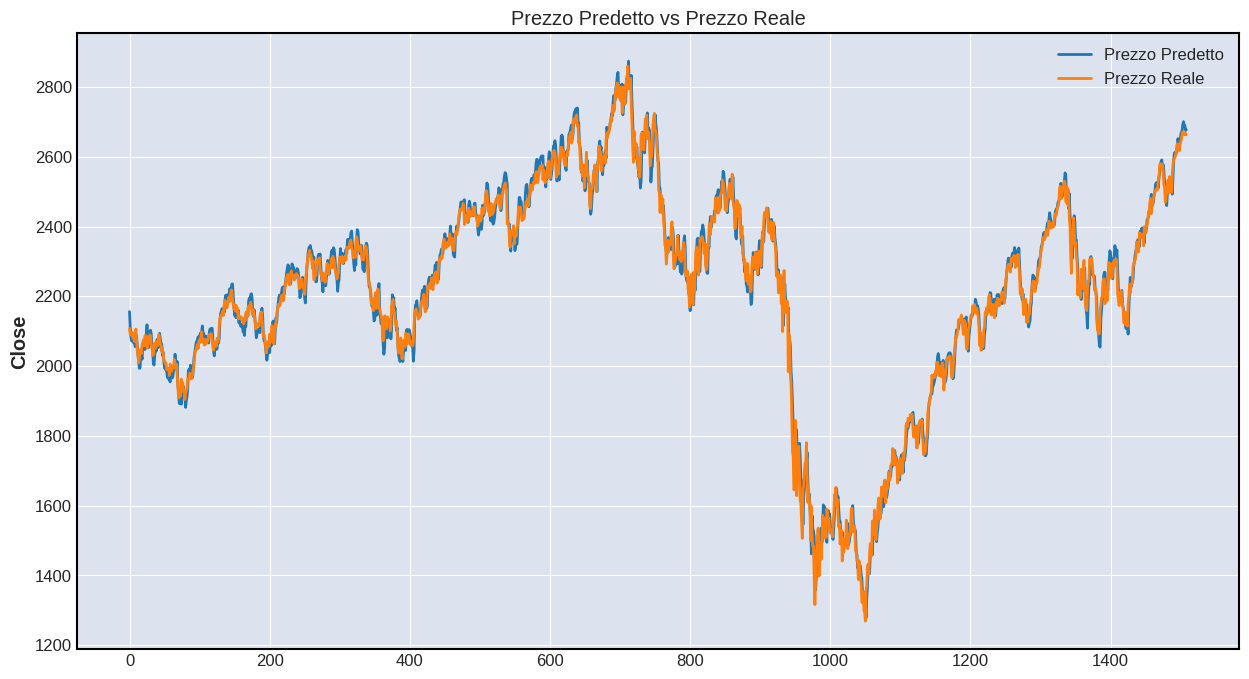

In [117]:
print_figure(X_val_polynomial, y_val, polynomial_dropped)

In [118]:
print_figure(X_val_polynomial[:200], y_val[:200], polynomial_dropped, 200)

Si osserva, specialmente nel grafico di 200 periodi, un'effettiva minore efficacia della predizione rispetto alla semplice regressione lineare.

#### Regressione Kernel Ridge

Effettuiamo ora un test di predizione sfruttando una regressione di tipo Kernel Ridge. 

Partiamo da una grid search sulla quale testiamo diversi iperparametri.

In [119]:
kernelridge = Pipeline([
    ("scale", None),
    ("regr", KernelRidge(kernel="rbf"))
])

grid = {
    "scale": [None, StandardScaler()],
    "regr__gamma": [0.001, 0.01, 0.1],
    "regr__alpha": np.logspace(-3, 2, 6)
}

In [120]:
gs = GridSearchCV(kernelridge, grid, cv=tss, scoring=roi_scorer)
gs.fit(X_train, y_train);
sel = ["rank_test_score","mean_test_score","params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

rank_test_score  ...                                             params
1                 1  ...  {'regr__alpha': 0.001, 'regr__gamma': 0.001, '...
3                 2  ...  {'regr__alpha': 0.001, 'regr__gamma': 0.01, 's...
7                 3  ...  {'regr__alpha': 0.01, 'regr__gamma': 0.001, 's...
9                 4  ...  {'regr__alpha': 0.01, 'regr__gamma': 0.01, 'sc...
15                5  ...  {'regr__alpha': 0.1, 'regr__gamma': 0.01, 'sca...
13                6  ...  {'regr__alpha': 0.1, 'regr__gamma': 0.001, 'sc...
19                7  ...  {'regr__alpha': 1.0, 'regr__gamma': 0.001, 'sc...
11                8  ...  {'regr__alpha': 0.01, 'regr__gamma': 0.1, 'sca...
17                9  ...  {'regr__alpha': 0.1, 'regr__gamma': 0.1, 'scal...
21               10  ...  {'regr__alpha': 1.0, 'regr__gamma': 0.01, 'sca...
5                11  ...  {'regr__alpha': 0.001, 'regr__gamma': 0.1, 'sc...
23               12  ...  {'regr__alpha': 1.0, 'regr__gamma': 0.1, 'scal...
27               13  ...  {'regr__alpha': 10.0, 'regr__gamma': 0.01, 'sc...
33               14  ...  {'regr__alpha': 100.0, 'regr__gamma': 0.01, 's...
25               15  ...  {'regr__alpha': 10.0, 'regr__gamma': 0.001, 's...
31               16  ...  {'regr__alpha': 100.0, 'regr__gamma': 0.001, '...
29               17  ...  {'regr__alpha': 10.0, 'regr__gamma': 0.1, 'sca...
14               18  ...  {'regr__alpha': 0.1, 'regr__gamma': 0.01, 'sca...
32               18  ...  {'regr__alpha': 100.0, 'regr__gamma': 0.01, 's...
30               18  ...  {'regr__alpha': 100.0, 'regr__gamma': 0.001, '...
28               18  ...  {'regr__alpha': 10.0, 'regr__gamma': 0.1, 'sca...
2                18  ...  {'regr__alpha': 0.001, 'regr__gamma': 0.01, 's...
26               18  ...  {'regr__alpha': 10.0, 'regr__gamma': 0.01, 'sc...
24               18  ...  {'regr__alpha': 10.0, 'regr__gamma': 0.001, 's...
4                18  ...  {'regr__alpha': 0.001, 'regr__gamma': 0.1, 'sc...
22               18  ...  {'regr__alpha': 1.0, 'regr__gamma': 0.1, 'scal...
20               18  ...  {'regr__alpha': 1.0, 'regr__gamma': 0.01, 'sca...
8                18  ...  {'regr__alpha': 0.01, 'regr__gamma': 0.01, 'sc...
10               18  ...  {'regr__alpha': 0.01, 'regr__gamma': 0.1, 'sca...
34               18  ...  {'regr__alpha': 100.0, 'regr__gamma': 0.1, 'sc...
16               18  ...  {'regr__alpha': 0.1, 'regr__gamma': 0.1, 'scal...
6                32  ...  {'regr__alpha': 0.01, 'regr__gamma': 0.001, 's...
0                32  ...  {'regr__alpha': 0.001, 'regr__gamma': 0.001, '...
12               34  ...  {'regr__alpha': 0.1, 'regr__gamma': 0.001, 'sc...
35               35  ...  {'regr__alpha': 100.0, 'regr__gamma': 0.1, 'sc...
18               36  ...  {'regr__alpha': 1.0, 'regr__gamma': 0.001, 'sc...

[36 rows x 3 columns]

Si osserva un ROI inferiore rispetto a quello dei modelli precedenti, proviamo ora ad effettuare un addestramento sul training set completo con gli iperparametri migliori.

In [99]:
kernelridge = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", KernelRidge(alpha=0.001, gamma=0.001, kernel="rbf"))
])

kernelridge.fit(X_train, y_train);

In [100]:
print_eval(X_val, y_val, kernelridge)

Scarto Quadratico Medio: 1680.5
Errore Relativo:         1.48908%
Coeff. Det. R²:          0.98169
Profitto:                19350.03$
ROI:                     873.382%


Tutte le metriche risultano peggiori rispetto al semplice modello lineare.

In [123]:
print_eval(X_val, y_val, kernelridge, delta=5)

Scarto Quadratico Medio: 1680.5
Errore Relativo:         1.48908%
Coeff. Det. R²:          0.98169
Profitto:                18885.60$
ROI:                     852.419%


L'introduzione del delta peggiora ulteriormente il risultato.

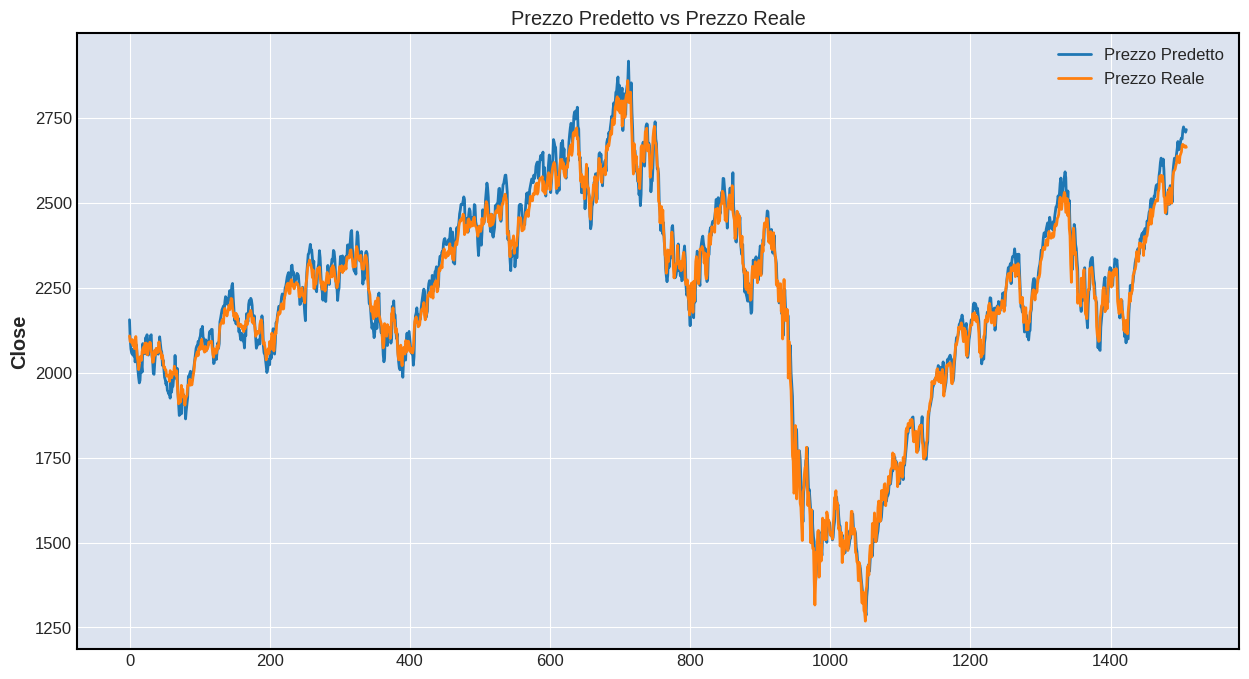

In [124]:
print_figure(X_val, y_val, kernelridge)

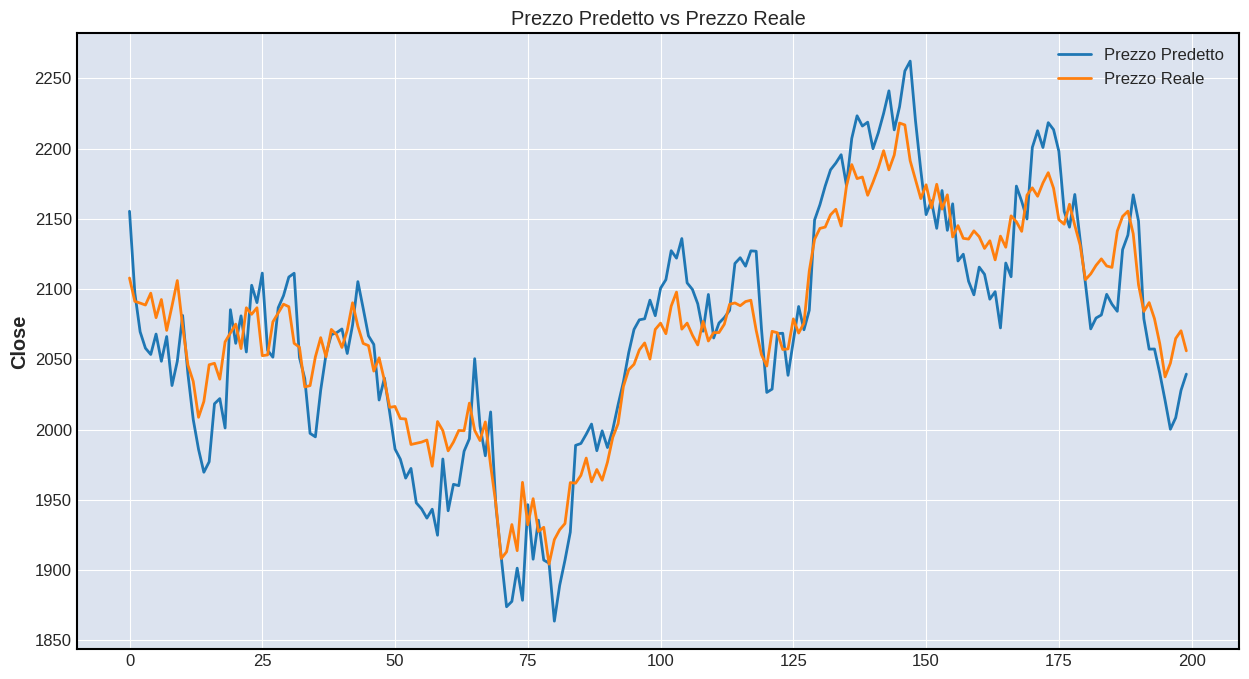

In [125]:
print_figure(X_val[:200], y_val[:200], kernelridge, 200)

Anche dai grafici si osserva un grado di approssimazione leggermente peggiore di quello dei modelli precedenti. Consideriamo tuttavia un *ROI* dell'873% comunque un buon risultato in 6 anni.

#### Regressione SVR

Testiamo ora la regressione SVR, effettuiamo anche in questo caso un grid search testando vai iperparametri ad eccezione del grado, che, per questioni di tempo di addestramento lasceremo a 3 come di default.

In [ ]:
svr = Pipeline([
    ("scale", StandardScaler()),
    ("svr", SVR())
])

grid = {
    "svr__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "svr__C": [1, 5, 10],
    "svr__coef0": [0.01, 0.5, 10],
    "svr__gamma": ["auto", "scale"]
}

In [ ]:
gs = GridSearchCV(svr, grid, cv=tss, scoring=roi_scorer)
gs.fit(X_train, y_train);
sel = ["rank_test_score","mean_test_score","params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

rank_test_score  ...                                             params
9                 1  ...  {'svr__C': 1, 'svr__coef0': 10, 'svr__gamma': ...
13                1  ...  {'svr__C': 1, 'svr__coef0': 10, 'svr__gamma': ...
61                3  ...  {'svr__C': 10, 'svr__coef0': 10, 'svr__gamma':...
57                3  ...  {'svr__C': 10, 'svr__coef0': 10, 'svr__gamma':...
37                5  ...  {'svr__C': 5, 'svr__coef0': 10, 'svr__gamma': ...
..              ...  ...                                                ...
49               67  ...  {'svr__C': 10, 'svr__coef0': 0.01, 'svr__gamma...
29               69  ...  {'svr__C': 5, 'svr__coef0': 0.01, 'svr__gamma'...
25               69  ...  {'svr__C': 5, 'svr__coef0': 0.01, 'svr__gamma'...
5                71  ...  {'svr__C': 1, 'svr__coef0': 0.01, 'svr__gamma'...
1                71  ...  {'svr__C': 1, 'svr__coef0': 0.01, 'svr__gamma'...

[72 rows x 3 columns]

Si osserva che il modello permette in svariati casi di raggiungere risultati positivi, che tuttavia restano molto al di sotto di quelli ottenuti dalla regressione lineare.

---

Visualizziamo gli iperparametri migliori e utilizziamoli per addestrare un modello sull'intero training set.

In [ ]:
gs.best_params_

{'svr__C': 1, 'svr__coef0': 10, 'svr__gamma': 'auto', 'svr__kernel': 'poly'}

Si decide di aggiungere a questo punto anche l'iperparametro relativo al grado per addestrare un modello con grado 5, pensando di ottenere un risultato migliore.

In [126]:
svr = Pipeline([
    ("scale",  StandardScaler()),
    ("svr", SVR(C=1, coef0=10, gamma="auto", kernel="poly", degree=5))
])

svr.fit(X_train, y_train);

In [127]:
print_eval(X_val, y_val, svr)

Scarto Quadratico Medio: 1462.6
Errore Relativo:         1.30978%
Coeff. Det. R²:          0.98406
Profitto:                19835.65$
ROI:                     895.301%


Il risultato è effettivamente migliore di quello che avremmo ottenuto con grado 3, ma resta comunque al di sotto di altri modelli anche per quanto riguarda le altre metriche.

In [ ]:
print_eval(X_val, y_val, svr, delta=5)

Scarto Quadratico Medio: 1462.6
Errore Relativo:         1.30978%
Coeff. Det. R²:          0.98406
Profitto:                20201.11$
ROI:                     911.796%


L'introduzione del delta riesce a migliorare leggermente il *ROI*.

---

Visualizziamo ora i grafici.


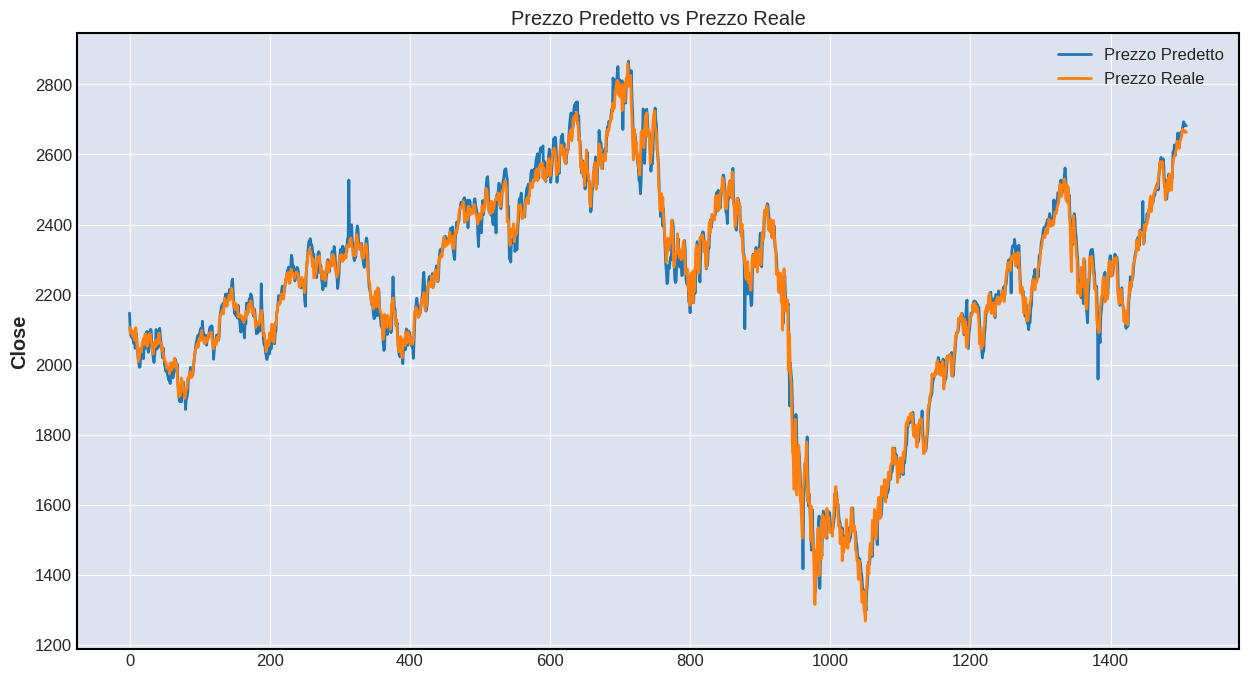

In [ ]:
print_figure(X_val, y_val, svr)

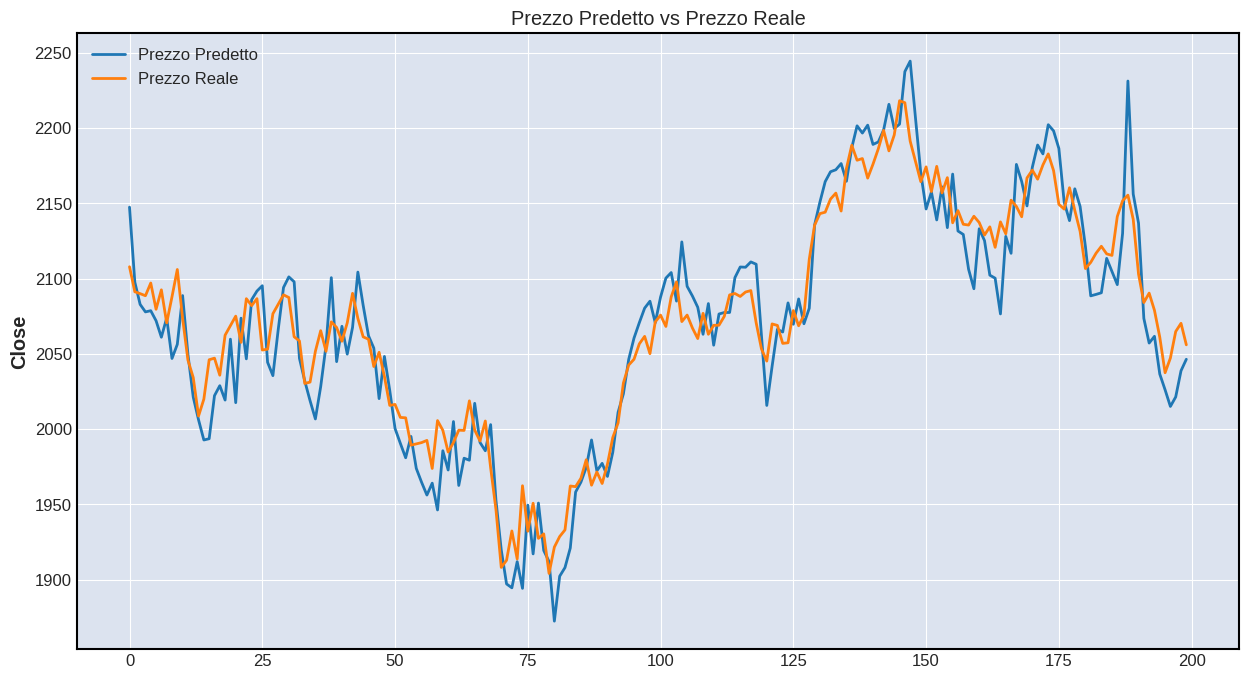

In [ ]:
print_figure(X_val[:200], y_val[:200], svr, 200)

Osserviamo che il modello, in particolar modo in presenza di picchi sia a rialzo che ha ribasso, effettua predizioni rispettivamente molto maggiori o molto minori del valore effettivamente raggiunto dall'indice.

#### Regressione tramite Decision Tree

Effettuiamo un test anche con un albero di regressione, anche se sarà difficile ottenere risultati accurati utilizzando un solo albero per un problema di tale complessità.

Impostiamo una grid search per individuare gli iperparametri migliori.

In [ ]:
decision_tree = Pipeline([
    ("scale", None),
    ("decisionTree", DecisionTreeRegressor(random_state=42))
])

grid = {
    "scale": [None, StandardScaler()],
    "decisionTree__max_depth": [None, 3, 5, 10],
    "decisionTree__min_samples_split": [0.05, 0.02, 0.1, 2]
}

In [ ]:
gs = GridSearchCV(decision_tree, grid, cv=tss, scoring=roi_scorer)
gs.fit(X_train, y_train);
sel = ["rank_test_score","mean_test_score","params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

rank_test_score  ...                                             params
7                 1  ...  {'decisionTree__max_depth': None, 'decisionTre...
6                 2  ...  {'decisionTree__max_depth': None, 'decisionTre...
31                3  ...  {'decisionTree__max_depth': 10, 'decisionTree_...
30                3  ...  {'decisionTree__max_depth': 10, 'decisionTree_...
2                 5  ...  {'decisionTree__max_depth': None, 'decisionTre...
3                 5  ...  {'decisionTree__max_depth': None, 'decisionTre...
27                5  ...  {'decisionTree__max_depth': 10, 'decisionTree_...
26                5  ...  {'decisionTree__max_depth': 10, 'decisionTree_...
1                 9  ...  {'decisionTree__max_depth': None, 'decisionTre...
25                9  ...  {'decisionTree__max_depth': 10, 'decisionTree_...
24                9  ...  {'decisionTree__max_depth': 10, 'decisionTree_...
0                 9  ...  {'decisionTree__max_depth': None, 'decisionTre...
4                13  ...  {'decisionTree__max_depth': None, 'decisionTre...
29               13  ...  {'decisionTree__max_depth': 10, 'decisionTree_...
28               13  ...  {'decisionTree__max_depth': 10, 'decisionTree_...
5                13  ...  {'decisionTree__max_depth': None, 'decisionTre...
16               17  ...  {'decisionTree__max_depth': 5, 'decisionTree__...
17               17  ...  {'decisionTree__max_depth': 5, 'decisionTree__...
23               19  ...  {'decisionTree__max_depth': 5, 'decisionTree__...
22               19  ...  {'decisionTree__max_depth': 5, 'decisionTree__...
19               21  ...  {'decisionTree__max_depth': 5, 'decisionTree__...
18               21  ...  {'decisionTree__max_depth': 5, 'decisionTree__...
20               23  ...  {'decisionTree__max_depth': 5, 'decisionTree__...
21               23  ...  {'decisionTree__max_depth': 5, 'decisionTree__...
13               25  ...  {'decisionTree__max_depth': 3, 'decisionTree__...
10               25  ...  {'decisionTree__max_depth': 3, 'decisionTree__...
9                25  ...  {'decisionTree__max_depth': 3, 'decisionTree__...
8                25  ...  {'decisionTree__max_depth': 3, 'decisionTree__...
11               25  ...  {'decisionTree__max_depth': 3, 'decisionTree__...
15               25  ...  {'decisionTree__max_depth': 3, 'decisionTree__...
14               25  ...  {'decisionTree__max_depth': 3, 'decisionTree__...
12               25  ...  {'decisionTree__max_depth': 3, 'decisionTree__...

[32 rows x 3 columns]

Come previsto, i risultati ottenuti non sono estremamente soddisfacenti, procediamo quindi ora con la visualizzazione degli iperparametri migliori e l'addestramento di un modello su tutto il training set.

In [ ]:
gs.best_params_

{'decisionTree__max_depth': None,
 'decisionTree__min_samples_split': 2,
 'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [128]:
decision_tree = Pipeline([
    ("scale",  StandardScaler()),
    ("tree", DecisionTreeRegressor(max_depth=None, min_samples_split=2))
])

decision_tree.fit(X_train, y_train);

In [129]:
print_eval(X_val, y_val, decision_tree)

Scarto Quadratico Medio: 8518.1
Errore Relativo:         3.26361%
Coeff. Det. R²:          0.9072
Profitto:                6947.82$
ROI:                     313.596%


Il modello presenta un *errore relativo* ed uno *scarto quadratico medio* elevati. Anche il coefficiente di determinazione *R²* è relativamente basso e il *ROI* non riesce a superare di molto il 300%.

In [ ]:
print_eval(X_val, y_val, decision_tree, delta=5)

Scarto Quadratico Medio: 8195.3
Errore Relativo:         3.19036%
Coeff. Det. R²:          0.91071
Profitto:                6353.91$
ROI:                     286.790%


Con l'introduzione del delta il *ROI* peggiora leggermente.

---

Procediamo ora con la visualizzazione grafica.

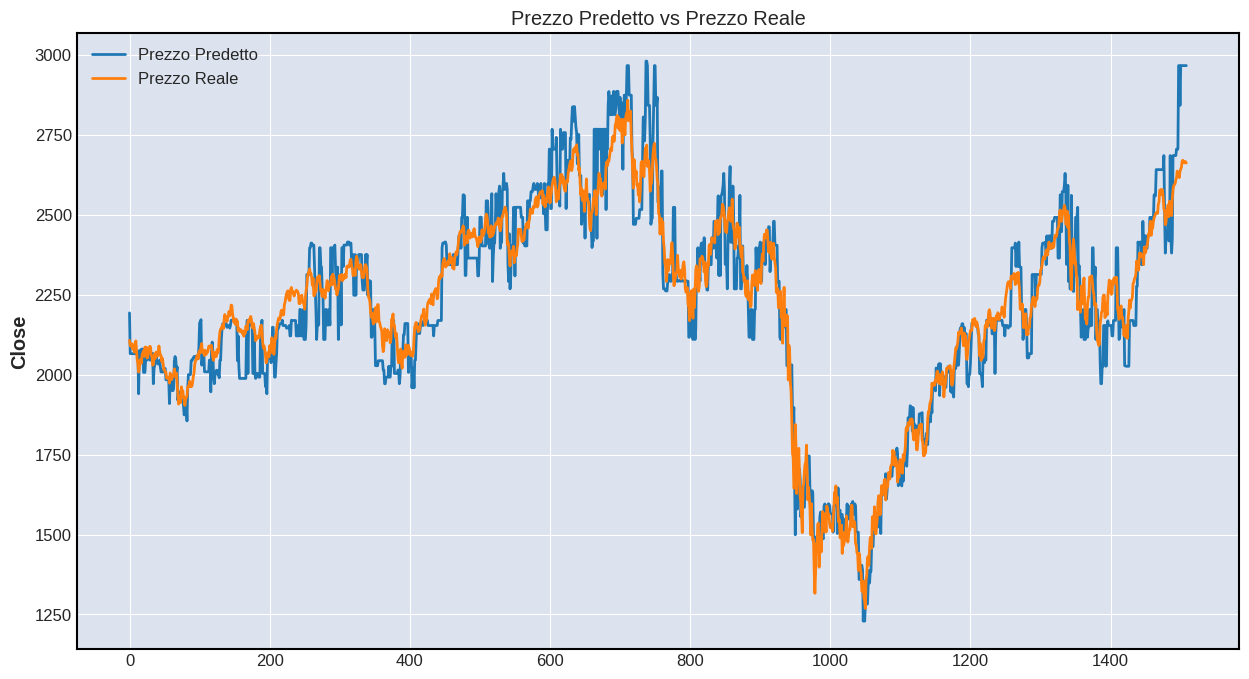

In [ ]:
print_figure(X_val, y_val, decision_tree)

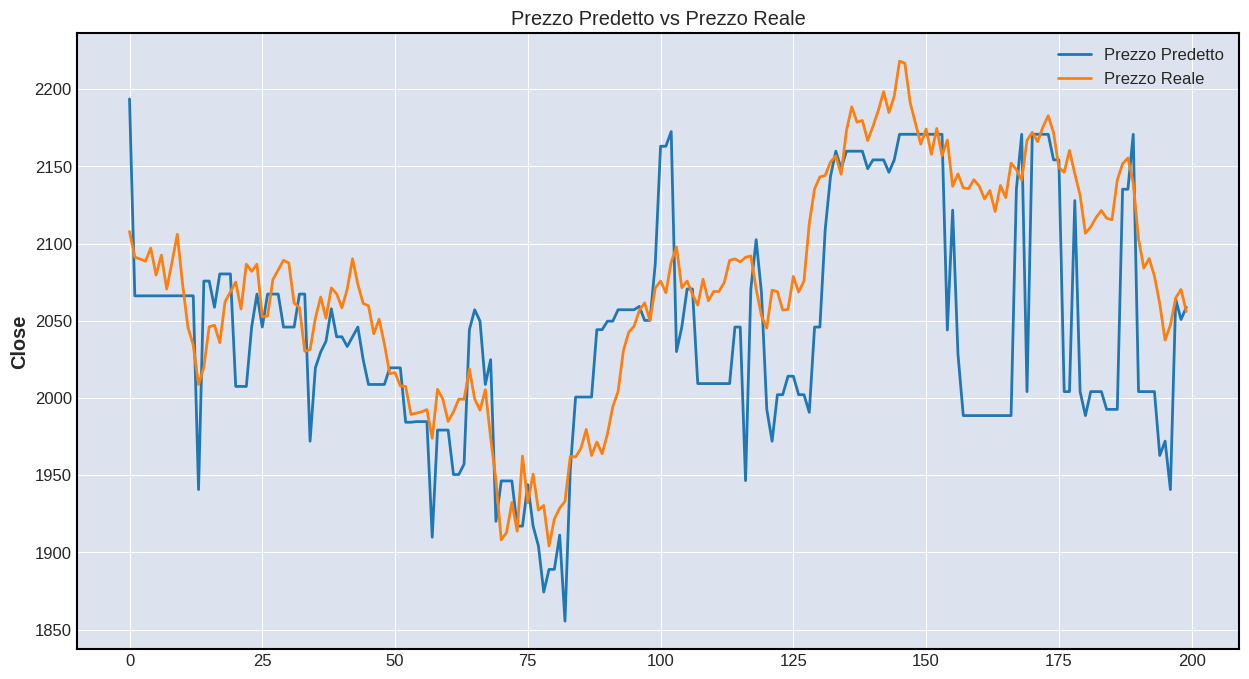

In [ ]:
print_figure(X_val[:200], y_val[:200], decision_tree, 200)

Dai grafici è evidente come il modello riesca ad abbozzare l'andamento del prezzo senza riuscire però a prevederlo con grande efficacia.

#### Regressione tramite XGBoost

Come ultimo tentativo per cercare di superare la regressione lineare testiamo l'utilizzo di una foresta di alberi attraverso XGBoost.

Utilizziamo anche in questo caso una grid search per individuare gli iperparametri migliori.

In [ ]:
xgboost_regressor = Pipeline([
    ("scale", None),
    ("xgb", XGBRegressor(random_state=42, objective="reg:squarederror"))
])

grid = {
    "scale": [None, StandardScaler()],
    "xgb__n_estimators": [100, 200, 300, 400],
    "xgb__learning_rate": [0.001, 0.005, 0.01, 0.05],
    "xgb__max_depth": [8, 10, 12, 15],
    "xgb__gamma": [0.001, 0.005, 0.01, 0.02]
}

In [ ]:
gs = GridSearchCV(xgboost_regressor, grid, cv=tss, scoring=roi_scorer)
gs.fit(X_train, y_train);
sel = ["rank_test_score","mean_test_score","params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

rank_test_score  ...                                             params
307                1  ...  {'scale': StandardScaler(copy=True, with_mean=...
51                 1  ...  {'scale': None, 'xgb__gamma': 0.001, 'xgb__lea...
243                3  ...  {'scale': None, 'xgb__gamma': 0.02, 'xgb__lear...
499                3  ...  {'scale': StandardScaler(copy=True, with_mean=...
435                5  ...  {'scale': StandardScaler(copy=True, with_mean=...
..               ...  ...                                                ...
202              193  ...  {'scale': None, 'xgb__gamma': 0.02, 'xgb__lear...
201              193  ...  {'scale': None, 'xgb__gamma': 0.02, 'xgb__lear...
200              193  ...  {'scale': None, 'xgb__gamma': 0.02, 'xgb__lear...
199              193  ...  {'scale': None, 'xgb__gamma': 0.02, 'xgb__lear...
256              193  ...  {'scale': StandardScaler(copy=True, with_mean=...

[512 rows x 3 columns]

I risultati ottenuti sono migliori di quelli con un solo albero ma comunque non estremamente soddisfacenti.

Visualizziamo i migliori iperparametri per addestrare un modello su tutto il training set.

In [ ]:
gs.best_params_

{'scale': None,
 'xgb__gamma': 0.001,
 'xgb__learning_rate': 0.05,
 'xgb__max_depth': 8,
 'xgb__n_estimators': 400}

In [130]:
xgboost_regressor = XGBRegressor(gamma=0.001, learning_rate=0.05, max_depth=8, n_estimators=400, random_state=42, objective="reg:squarederror")

xgboost_regressor.fit(X_train, y_train);

In [131]:
print_eval(X_val, y_val, xgboost_regressor)

Scarto Quadratico Medio: 2398.2
Errore Relativo:         1.78079%
Coeff. Det. R²:          0.97387
Profitto:                13343.58$
ROI:                     602.275%


Otteniamo un risultato medio non estremamente soddisfacente e che non riesce ad avvicinarsi alla regressione lineare.

In [ ]:
print_eval(X_val, y_val, xgboost_regressor, delta=5)

Scarto Quadratico Medio: 2398.2
Errore Relativo:         1.78079%
Coeff. Det. R²:          0.97387
Profitto:                13054.13$
ROI:                     589.210%


L'introduzione del delta anche in questo caso non porta nessun vantaggio.

---

Stampiamo ora i grafici.

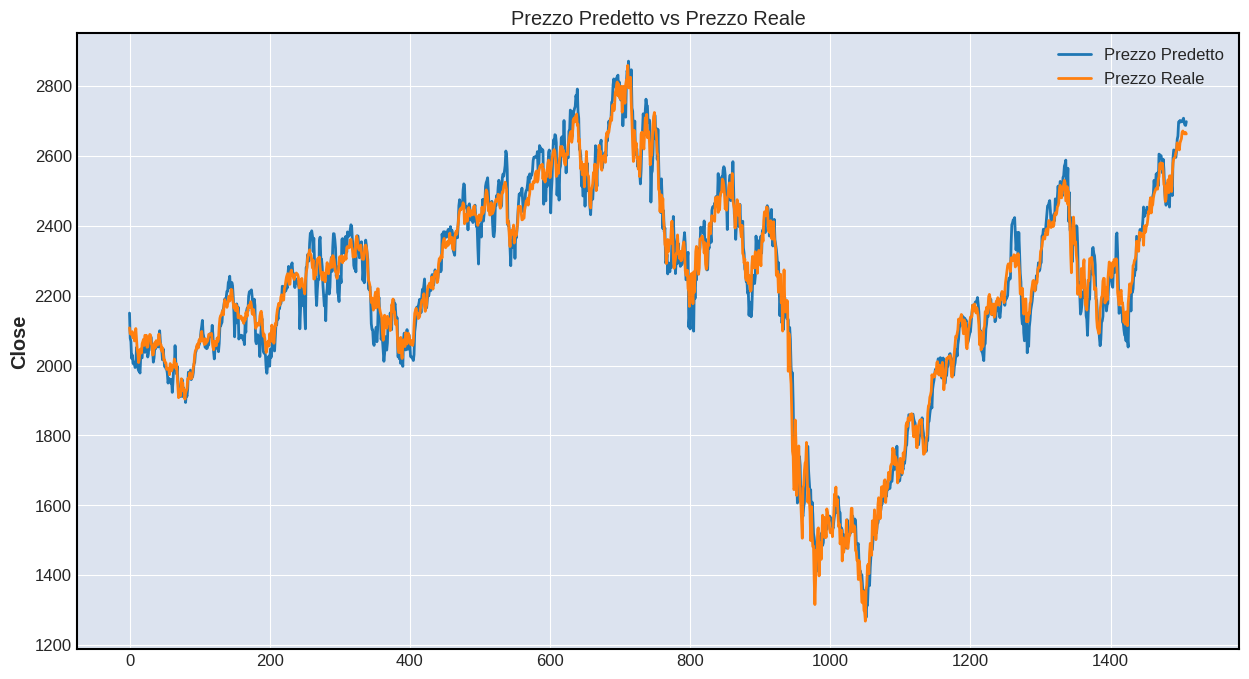

In [ ]:
print_figure(X_val, y_val, xgboost_regressor)

In [ ]:
print_figure(X_val[:200], y_val[:200], xgboost_regressor, 200)

Si osserva, soprattutto nel grafico a 200 periodi, che il modello segue si l'andamento generale del prezzo, ma amplifica troppo i massimi e i minimi rendendolo non particolarmente affidabile sul breve periodo.

#### Test con modello casuale

Eseguiamo ora un test di predizione con un modello casuale, per verificare se i nostri modelli permettono effettivamente di generare una predizione più efficace di una affidata al caso.

Per rendere il modello casuale più efficace si decide di considerare la distribuzione del prezzo di chiusura del validation set. Osserviamola in un grafico.

In [ ]:
sns.displot(y_train);

La distribuzione non è ben definita, si osserva però che potrebbe essere approssimata in linea di massima da un modello casuale esponenziale.

Procediamo con la predizione di valori casuali secondo un modello esponenziale.

In [ ]:
np.random.seed(42)
random_preds = np.random.exponential(scale=y_train.mean(), size=len(y_val))

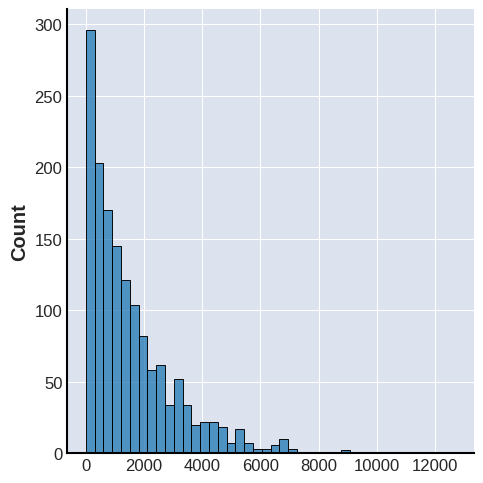

In [ ]:
sns.displot(random_preds);

Osserviamo che la distribuzione ricorda molto vagamente quella del validation set.

Procediamo ora con la valutazione delle metriche.

In [ ]:
print("Scarto Quadratico Medio: {:.5}".format(mean_squared_error(y_val, random_preds)))
print("Errore Relativo:         {:.5%}".format(np.mean(np.abs((y_val - random_preds) / y_val))))
print("Coeff. Det. R²:          {:.5}".format(r2_score(y_val, random_preds)))
print("Profitto:                {:.2f}$".format(gain(y_val, random_preds, 0)))
print("ROI:                     {:.3%}".format(roi(y_val, random_preds, 0)))

Scarto Quadratico Medio: 3.0082e+06
Errore Relativo:         65.93504%
Coeff. Det. R²:          -31.774
Profitto:                1042.25$
ROI:                     47.043%


Si può notare che il modello casuale garantisce un *ROI* di appena il 47% in 6 anni, ben distante dal 1070% del nostro migliore modello e comunque da ogni altro modello generato nel corso del caso di studio. Inoltre anche lo scarto quadratico medio e l'errore relativo risultano molto elevati.

---

Visualizziamo ora un grafico a 200 periodi che ci confermerà l'enorme differenza tra i valori di chiusura predetti e quelli reali.

In [ ]:
y_predicted = random_preds[:200]
y_true = y_val[:200]
plt.figure(figsize=(15, 8))
sns.lineplot(y=y_predicted, x=np.arange(200))
sns.lineplot(y=y_true, x=np.arange(200))
plt.legend(["Prezzo Predetto", "Prezzo Reale"])
plt.title("Prezzo Predetto vs Prezzo Reale")
plt.show()

Possiamo quindi concludere asserendo che nessuno dei modelli generati è assimilabile ad un modello casuale, in quanto tutti i nostri modelli ottengono degli score nettamente migliori rispetto a quest'ultimo.

## Confronto tra i modelli e scelta dei migliori

### Definizione metriche di confronto

Per il confronto conclusivo tra i vari modelli si decide di introdurre una nuova metrica di valutazione, l'intervallo di confidenza al 95%. Si tratta di un intervallo entro il quale la predizione può considerarsi efficace al 95%, nel senso che il valore reale ricadrà all'interno di questo intervallo sia al di sopra che al di sotto del valore predetto nel 95% dei casi. Questa metrica aiuta quindi a stimare quale modello è più affidabile.

Definiamone il calcolo nella seguente funzione.

In [132]:
from scipy import stats

def get_confidence_interval(prediction, y_test, test_predictions, pi=.95):
    #calcoliamo la deviazione standard della predizione
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    #ricaviamo l'intervallo di confidenza (in questo caso al 95%) dalla deviazione standard
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    return interval

Definiamo ora una funzione che ci permetta di stampare questa metrica insieme a quelle già calcolate e nello stesso formato.

In [133]:
def print_all_metrics(model, X_val=X_val):
    print_eval(X_val, y_val, model)
    interval = get_confidence_interval(model.predict(X_val[:1]), y_val, model.predict(X_val))
    print("I. di Confidenza al 95%: {:.5}".format(interval))

Infine introduciamo una funzione che si occuperà di effettuare la stampa di tutte le metriche relative a tutti i modelli generati.

In [134]:
def print_all_models():
    print("Regressione Lasso:")
    print("-----------------------------------")
    print_all_metrics(lasso)
    print("-----------------------------------")
    print("Regressione Ridge:")
    print("-----------------------------------")
    print_all_metrics(ridge)
    print("-----------------------------------")
    print("Regressione Lineare:")
    print("-----------------------------------")
    print_all_metrics(linreg)
    print("-----------------------------------")
    print("Regressione Polinomiale:")
    print("-----------------------------------")
    print_all_metrics(polynomial_dropped, X_val_polynomial)
    print("-----------------------------------")
    print("Regressione Kernel Ridge:")
    print("-----------------------------------")
    print_all_metrics(kernelridge)
    print("-----------------------------------")
    print("Regressione SVR:")
    print("-----------------------------------")
    print_all_metrics(svr)
    print("-----------------------------------")
    print("Regressione Decision Tree:")
    print("-----------------------------------")
    print_all_metrics(decision_tree)
    print("-----------------------------------")
    print("Regressione XGBoost:")
    print("-----------------------------------")
    print_all_metrics(xgboost_regressor)

### Confronto e scelta

Si sfruttano ora le funzioni appena definite per la stampa delle metriche relative a tutti i modelli generati nel corso del caso di studio.

In [135]:
print_all_models()

Regressione Lasso:
-----------------------------------
Scarto Quadratico Medio: 1389.8
Errore Relativo:         1.31823%
Coeff. Det. R²:          0.98486
Profitto:                13733.95$
ROI:                     619.895%
I. di Confidenza al 95%: 73.116
-----------------------------------
Regressione Ridge:
-----------------------------------
Scarto Quadratico Medio: 970.74
Errore Relativo:         1.06988%
Coeff. Det. R²:          0.98942
Profitto:                23692.83$
ROI:                     1069.398%
I. di Confidenza al 95%: 61.106
-----------------------------------
Regressione Lineare:
-----------------------------------
Scarto Quadratico Medio: 970.79
Errore Relativo:         1.06939%
Coeff. Det. R²:          0.98942
Profitto:                23752.15$
ROI:                     1072.075%
I. di Confidenza al 95%: 61.108
-----------------------------------
Regressione Polinomiale:
-----------------------------------
Scarto Quadratico Medio: 1201.1
Errore Relativo:         1.222

Dopo un'attenta analisi dei risultati ottenuti, tenendo conto dell'intervallo di confidenza, riusciamo ad individuare tre modelli che riescono ad approssimare in maniera efficace il problema. Questi sono **ridge**, **linreg** e **polynomial_dropped**, ovvero il modello di regressione polinomiale di secondo grado che è stato addestrato escludendo le features estrapolate da *Date*. In linea di massima si osserva come i modelli più semplici riescono ad ottenere risultati migliori su questo problema. Probabilmente i modelli più complessi come ad esempio XGBoost vanno in overfitting, non riuscendo ad ottenere un'approssimazione efficace sul validation set.

Dovendo scegliere un modello migliore e ragionando in termini di efficienza la scelta ricade sul **linreg**, ovvero la regressione lineare. Questo modello permette infatti di ottenere i risultati migliori senza adottare nessun tipo di regolarizzazione o effettuare l'aggiunta di altre variabili per l'attuazione di una regressione polinomiale. Questo è il modello che garantisce inoltre il *ROI* più elevato, con un ritorno sull'investimento del 1072% sui sei anni del validation set. Lo scarto quadratico medio ottenuto è di 970.79, il più basso dopo il 970.74 della **ridge**. L'errore relativo si attesta sull'1%, mentre il coefficiente di determinazione R² si attesta quasi sullo 0.99. Infine l'intervallo di confidenza al 95% è il più basso registrato, sempre dopo quello della **ridge**, ma, come nel caso dello scarto quadratico medio, differiscono di qualche cifra decimale irrisoria. La grande somiglianza tra **linreg** e **ridge** è probabilmente dovuta al fatto che attraverso il grid search sul secondo è risultato più performante il parametro alpha minore, rendendo la regolarizzazione quasi nulla. I due modelli sono quindi molto simili.

### Interpretazione della conoscenza appresa dal modello

Visualizziamo ora i pesi in ordine decrescente per osservare quali features hanno contribuito maggiormente nella predizione.

In [145]:
get_coeff(linreg).sort_values(ascending=False).head(13)

Month               29.637879
Is_year_end         16.167127
MACD                10.620947
Is_month_end         9.190594
Is_month_start       3.284701
SMA_10               1.665221
SMA_15               1.481778
SMA_25               1.048023
Day                  0.988464
SMA_20               0.960830
SMA_30               0.875258
Is_quarter_start     0.581069
Stochastic           0.204410
dtype: float64

Sorprendentemente, tra i pesi positivi maggiori troviamo quelli relativi alla data, quali *Month* e *Is_year_end*, che, nonostante la bassa correlazione con il prezzo di chiusura hanno un peso elevato nella sua determinazione. Tuttavia, questo peso è notevolmente ridimensionato se consideriamo i valori assunti da queste features che sono di uno e due ordini di grandezza inferiori rispetto agli indicatori economici dello stesso ordine di grandezza del prezzo. Come indice dal maggior peso positivo abbiamo il *MACD*, ma anche questo valore è da prendere con le pinze, in quanto costituito dalla differenza di due medie, mentre le medie mobili, che apparentemente influiscono sulla predizione in minor misura, sono quelle che invece vi contribuiscono maggiormente, dato che saranno moltiplicate per valori in ingresso nell'ordine delle migliaia.



---



Osserviamo ora i coefficienti che causano invece un abbassamento del prezzo predetto.

In [147]:
get_coeff(linreg).sort_values().head(8)

Is_quarter_end   -17.490636
MACD_signal       -9.009045
EMA_9             -4.443869
Dayofyear         -0.955975
SMA_5             -0.587850
Dayofweek         -0.162029
Week              -0.149591
RSI               -0.141836
dtype: float64

Anche qui notiamo come pesi di maggior importanza in negativo alcuni pesi particolari, come *Is_quarter_end* e *MACD_signal*, che, come già detto, non sono indice di maggior influenza in quanto vanno moltiplicati rispettivamente per una variabile booleana e una differenza tra due medie. Proseguiamo affermando che la feature che impatta maggiormente sul prezzo è la *EMA_9*, ovvero la media mobile esponenziale a 9 periodi. Infatti, nonostante il suo peso sia inferiore di quello di altre features, questa prende in input dati dello stesso ordine di grandezza del prezzo di chiusura, ne risulta quindi un peso decisamente maggiore rispetto al prodotto tra 17 e una variabile booleana.

In conclusione, possiamo affermare che le features che contribuiscono maggiormente alla predizione del prezzo sono, come prevedibile, quelle relative alle medie mobili, che possiedono, per definizione, un ampio contenuto informativo sul prezzo di chiusura delle giornate precedenti che sono oggetto del calcolo della media stessa.

## Conclusioni

Tramite l'analisi di questo dominio applicativo si è riuscito ad estrarre un modello di regressione semplice, con buona precisione e coerente con la realtà.

L'idea era quella di provare a prevedere l'andamento di un indice, task che ritengo personalmente abbastanza complesso.

Mi ritengo personalmente soddisfatto dei risultati ottenuti e ritengo che lavorarci sopra mi abbia fornito spunti interessanti su cui riflettere. Sicuramente in futuro proverò ad affrontare nuovamente il problema cercando di ottenere risultati migliori anche con i modelli più complessi, che, purtroppo, in questo particolare caso di studio hanno fornito predizioni non sufficientemente accurate sul validation set, portando a pensare ad un probabile problema di overfitting.